In [20]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 使用SMOTE处理训练数据不平衡问题
from imblearn.over_sampling import SMOTE
import os
# Set plot style for nicer visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [21]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X_df = bank_marketing.data.features
y_df = bank_marketing.data.targets
df = pd.concat([X_df, y_df], axis=1)
# Display metadata and variable information (as you provided)
print("--- Dataset Metadata ---")
print(bank_marketing.metadata)
print("\n--- Variable Information ---")
print(bank_marketing.variables)

--- Dataset Metadata ---
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven 

In [22]:
# 3. Initial Data Exploration

df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [23]:
# Target variable: 'y' - has the client subscribed a term deposit? (binary: "yes","no")
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [24]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


处理缺失值

缺失值都出现在类别变量里，在这类变量里unkown也保留一定信息，同时符合数据定义

In [25]:

print("--- 原始缺失值统计 ---")
print(df.isnull().sum())

# 需要处理缺失值的列
columns_with_nan = ['job', 'education', 'contact', 'poutcome']

# 对于这些特定的类别列，将 NaN 填充为 "unknown"
for col in columns_with_nan:
    if df[col].isnull().any(): # 检查该列是否确实存在缺失值
        print(f"正在将列 '{col}' 中的 NaN 填充为 'unknown'...")
        df[col] = df[col].fillna("unknown")

print("\n--- 处理后缺失值统计 ---")
print(df.isnull().sum())

--- 原始缺失值统计 ---
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64
正在将列 'job' 中的 NaN 填充为 'unknown'...
正在将列 'education' 中的 NaN 填充为 'unknown'...
正在将列 'contact' 中的 NaN 填充为 'unknown'...
正在将列 'poutcome' 中的 NaN 填充为 'unknown'...

--- 处理后缺失值统计 ---
age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64


In [26]:
#创建符号变量，没联系过是0，联系过是1
df['pdays_was_contacted'] = (df['pdays'] != -1).astype(int)
df['pdays_was_contacted'] = df['pdays_was_contacted'].astype('category')
df['pdays_log1p'] = df['pdays'].copy() # 先复制
df.loc[df['pdays_log1p'] == -1, 'pdays_log1p'] = 0 # 将-1映射到0，因为log1p(0)=0
df['pdays_log1p'] = np.log1p(df['pdays_log1p'])

# 1. 创建 'balance_sign' 特征
df['balance_sign'] = np.sign(df['balance'])
# 可以进一步映射为类别: {-1: 'negative', 0: 'zero', 1: 'positive'}
df['balance_sign_category'] = df['balance_sign'].map({-1: 'negative', 0: 'zero', 1: 'positive'}).astype('category')
print("\n创建 'balance_sign' 和 'balance_sign_category' 特征:")
print(df[['balance', 'balance_sign', 'balance_sign_category']].head())

# 2. 对 'balance' 的绝对值进行 log1p 变换
df['balance_log_abs_p1'] = np.log1p(np.abs(df['balance']))


创建 'balance_sign' 和 'balance_sign_category' 特征:
   balance  balance_sign balance_sign_category
0     2143             1              positive
1       29             1              positive
2        2             1              positive
3     1506             1              positive
4        1             1              positive


In [27]:
selected_features_for_X=[ 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'day_of_week', 'month', 'duration', 'campaign', 'previous',
    'poutcome', 'pdays_was_contacted', 'pdays_log1p',
     'balance_sign_category', 'balance_log_abs_p1']

df = df[selected_features_for_X + ['y']]
df.head(5)

,age,job,marital,education,default,housing,loan,contact,day_of_week,month,duration,campaign,previous,poutcome,pdays_was_contacted,pdays_log1p,balance_sign_category,balance_log_abs_p1,y
0,58,management,married,tertiary,no,yes,no,unknown,5,may,261,1,0,unknown,0,0.0,positive,7.670429,0
1,44,technician,single,secondary,no,yes,no,unknown,5,may,151,1,0,unknown,0,0.0,positive,3.401197,0
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,76,1,0,unknown,0,0.0,positive,1.098612,0
3,47,blue-collar,married,unknown,no,yes,no,unknown,5,may,92,1,0,unknown,0,0.0,positive,7.317876,0
4,33,unknown,single,unknown,no,no,no,unknown,5,may,198,1,0,unknown,0,0.0,positive,0.693147,0


In [28]:
# 识别类别特征和数值特征
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('y') # 从数值特征中移除目标变量
print("类别特征：", categorical_features
      ,"\n数值特征：", numerical_features)

类别特征： ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_was_contacted', 'balance_sign_category'] 
数值特征： ['age', 'day_of_week', 'duration', 'campaign', 'previous', 'pdays_log1p', 'balance_log_abs_p1']


创建pipeline减少重复操作

In [29]:
# 为数值和类别特征创建预处理管道
numerical_transformer = StandardScaler() # 数值特征标准化
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # 类别特征独热编码, drop='first' 避免多重共线性
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), # 数值转换器
        ('cat', categorical_transformer, categorical_features) # 类别转换器
    ])

In [30]:
# 在预处理目标变量后再次分离特征 (X) 和目标 (y)
X = df.drop('y', axis=1)
y = df['y']

开始划分训练测试集并尝试不同方法

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # stratify=y 确保类别比例一致
print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}") # 打印训练集和测试集形状
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (33908, 18), X_test shape: (11303, 18)
y_train shape: (33908,), y_test shape: (11303,)


f:\venv\env\sl\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



SMOTE重采样后的训练集形状:
X_train_smote shape: (59882, 45)
SMOTE后训练集类别分布:
y
0    0.5
1    0.5
Name: proportion, dtype: float64


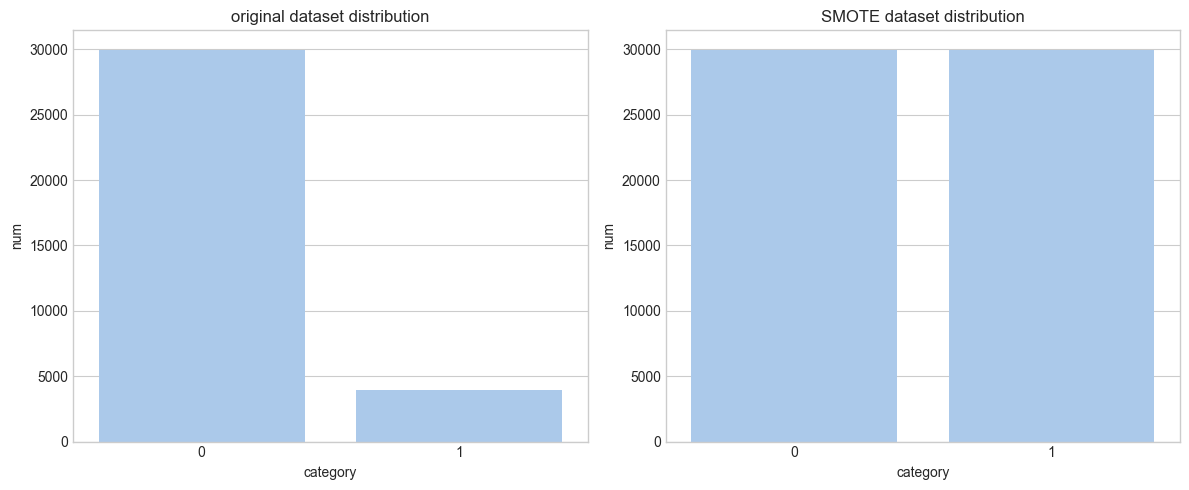

In [32]:
fitted_preprocessor = preprocessor.fit(X_train)
X_train_processed = fitted_preprocessor.transform(X_train)

# 检查是否是稀疏矩阵，如果是，则转换为稠密数组
if hasattr(X_train_processed, "toarray"):
    X_train_processed_dense = X_train_processed.toarray()
else:
    X_train_processed_dense = X_train_processed

# 应用SMOTE生成合成样本
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed_dense, y_train)

print("\nSMOTE重采样后的训练集形状:")
print(f"X_train_smote shape: {X_train_smote.shape}")
print("SMOTE后训练集类别分布:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

# 可视化SMOTE前后的类别分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('original dataset distribution')
plt.xlabel('category')
plt.ylabel('num')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('SMOTE dataset distribution')
plt.xlabel('category')
plt.ylabel('num')

plt.tight_layout()
plt.show()

In [33]:
imbalance_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"类别不平衡比例: {imbalance_ratio:.2f}")

类别不平衡比例: 7.55


In [76]:
models = {
    #TODO：可以调整逻辑回归的solver以及正则化参数，SVM的kernel等
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42), # 逻辑回归
    "Decision Tree": DecisionTreeClassifier(random_state=42), # 决策树
    "Random Forest": RandomForestClassifier(random_state=42), # 随机森林
     "Support Vector Machine (RBF Kernel)": SVC(kernel='rbf', gamma='scale', probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),# 朴素贝叶斯 (作为另一种统计/概率方法添加)
      "LightGBM": lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        n_jobs=-1,
        # class_weight='balanced'  # 处理类别不平衡
    ),
    "CatBoost": CatBoostClassifier(
    iterations=300,                  # 增加迭代次数以获得更好的收敛
    learning_rate=0.05,              # 降低学习率以更好地泛化
    depth=8,                         # 增加树深度以捕捉更复杂的模式
    loss_function='Logloss',
    l2_leaf_reg=3,                   # L2正则化参数，防止过拟合
    random_seed=42,
    eval_metric='AUC',               # 使用AUC作为评估指标，适合不平衡数据
    leaf_estimation_method='Newton', # 使用牛顿法可能获得更好的收敛
    verbose=0,                       # 减少输出信息
    
    # 处理不平衡数据的参数（替代SMOTE）
    auto_class_weights='Balanced',   # 自动平衡类别权重
    
    # 提高训练效率的参数
    thread_count=-1,                 # 使用所有可用CPU核心
    task_type='CPU',                 # 可根据环境改为'GPU'
    
    # 避免过拟合的参数
    bootstrap_type='Bayesian',       # 贝叶斯自举采样
    bagging_temperature=1,           # 控制贝叶斯采样的随机性强度
    
    # 特征重要性和交互
    max_ctr_complexity=2,            # 允许更复杂的类别特征组合
    grow_policy='Lossguide',         # 基于损失改进构建树
    min_data_in_leaf=10,             # 每个叶节点的最小样本数
    max_leaves=64                    # 树的最大叶子数
),
 "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=imbalance_ratio,  # 处理类别不平衡
        seed=42,
        tree_method='hist'  # 更快的训练速度
    )
}



In [77]:
# 为了CatBoost正确处理类别特征，我们需要识别它们的索引
categorical_indices = []
for i, column in enumerate(X_train.columns):
    if column in categorical_features:
        categorical_indices.append(i)

In [78]:
from sklearn.metrics import confusion_matrix

def g_mean_score(y_true, y_pred):
    """
    计算几何平均精度(G-mean): G-mean = √(Recall × Specificity)
    
    参数:
        y_true: 真实标签
        y_pred: 预测标签
        
    返回:
        g_mean: G-mean得分
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # 召回率/敏感性
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特异性
    
    g_mean = np.sqrt(recall * specificity)
    return g_mean

In [79]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_prob, model_name):
    """
    绘制精确率-召回率曲线(PR曲线)并计算曲线下面积(AUPRC)
    
    参数:
        y_true: 真实标签
        y_prob: 预测概率
        model_name: 模型名称
    
    返回:
        auprc: PR曲线下面积
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AUPRC = {auprc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # 添加随机分类器的基准线
    no_skill = np.sum(y_true) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], '--', color='gray', label=f'No Skill (AUPRC = {no_skill:.4f})')
    plt.legend(loc='best')
    
    plt.show()
    
    return auprc

In [80]:
results = {} # 存储评估结果
classification_reports = {} # 存储分类报告
confusion_matrices = {} # 存储混淆矩阵


--- Training and Evaluating: Logistic Regression 


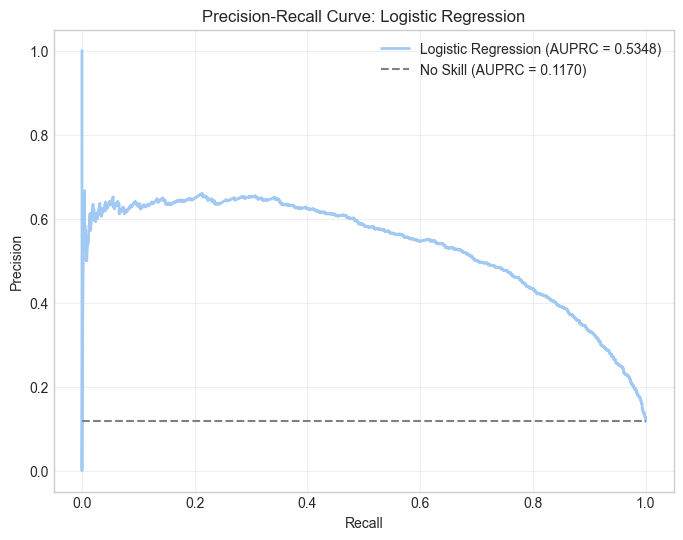

Accuracy: 0.8475
Precision: 0.4209
Recall: 0.8094
F1-score: 0.5538
G-mean: 0.8307
ROC AUC: 0.9066
AUPRC: 0.5348

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      9981
           1       0.42      0.81      0.55      1322

    accuracy                           0.85     11303
   macro avg       0.70      0.83      0.73     11303
weighted avg       0.91      0.85      0.87     11303



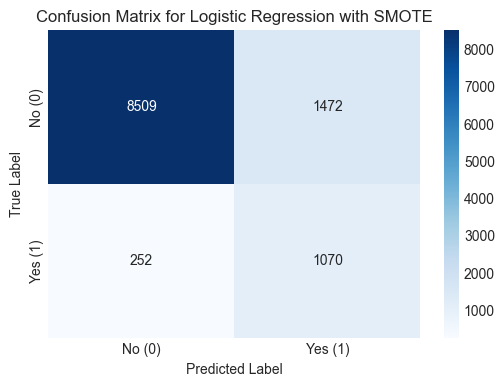


--- Training and Evaluating: Decision Tree 


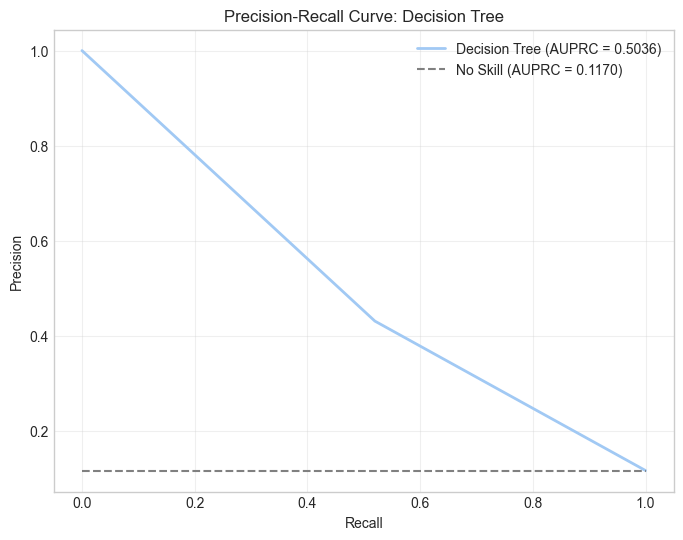

Accuracy: 0.8637
Precision: 0.4313
Recall: 0.5197
F1-score: 0.4714
G-mean: 0.6874
ROC AUC: 0.7144
AUPRC: 0.5036

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      9981
           1       0.43      0.52      0.47      1322

    accuracy                           0.86     11303
   macro avg       0.68      0.71      0.70     11303
weighted avg       0.88      0.86      0.87     11303



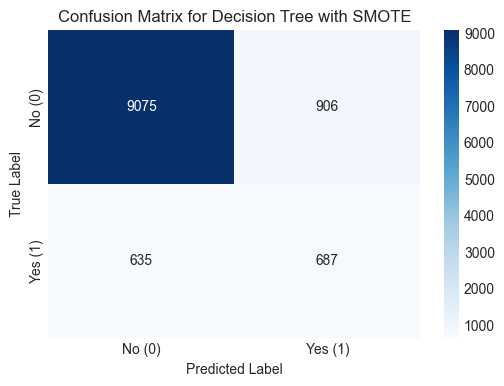


--- Training and Evaluating: Random Forest 


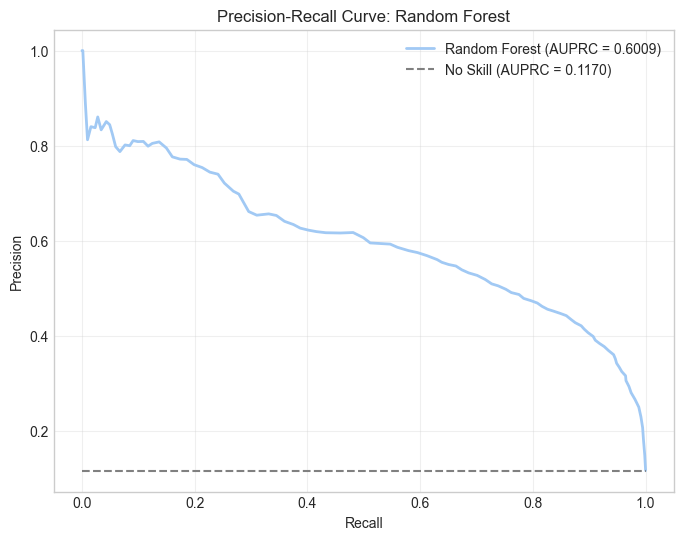

Accuracy: 0.9031
Precision: 0.5931
Recall: 0.5469
F1-score: 0.5691
G-mean: 0.7209
ROC AUC: 0.9268
AUPRC: 0.6009

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9981
           1       0.59      0.55      0.57      1322

    accuracy                           0.90     11303
   macro avg       0.77      0.75      0.76     11303
weighted avg       0.90      0.90      0.90     11303



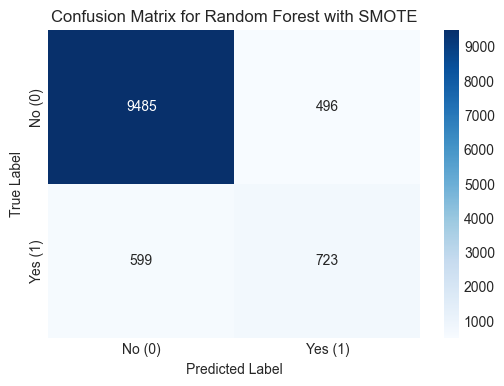


--- Training and Evaluating: Support Vector Machine (RBF Kernel) 


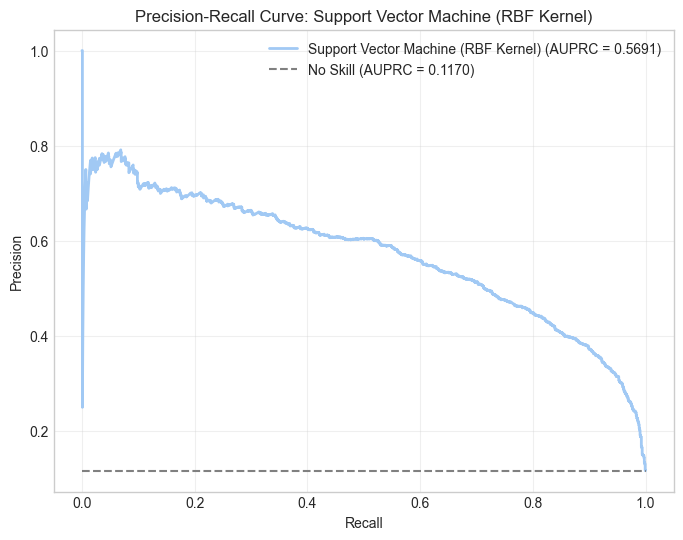

Accuracy: 0.8599
Precision: 0.4451
Recall: 0.8041
F1-score: 0.5730
G-mean: 0.8351
ROC AUC: 0.9175
AUPRC: 0.5691

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      9981
           1       0.45      0.80      0.57      1322

    accuracy                           0.86     11303
   macro avg       0.71      0.84      0.74     11303
weighted avg       0.91      0.86      0.88     11303



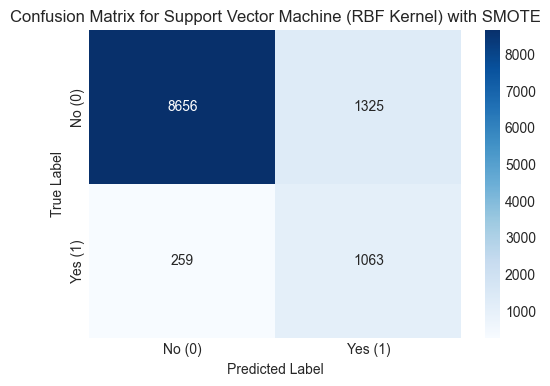


--- Training and Evaluating: Naive Bayes 


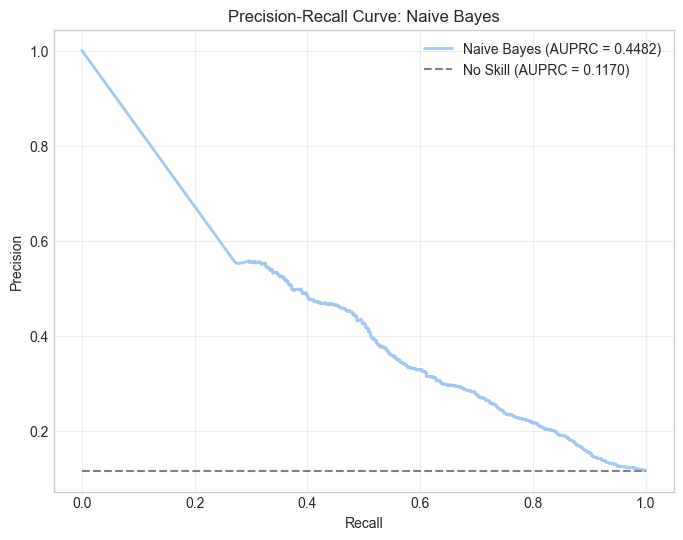

Accuracy: 0.8135
Precision: 0.3318
Recall: 0.5862
F1-score: 0.4237
G-mean: 0.7032
ROC AUC: 0.7864
AUPRC: 0.4482

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9981
           1       0.33      0.59      0.42      1322

    accuracy                           0.81     11303
   macro avg       0.64      0.71      0.66     11303
weighted avg       0.87      0.81      0.83     11303



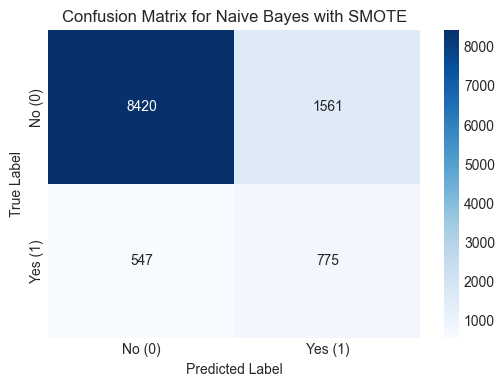


--- Training and Evaluating: LightGBM 
[LightGBM] [Info] Number of positive: 29941, number of negative: 29941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10614
[LightGBM] [Info] Number of data points in the train set: 59882, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

f:\venv\env\sl\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
f:\venv\env\sl\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


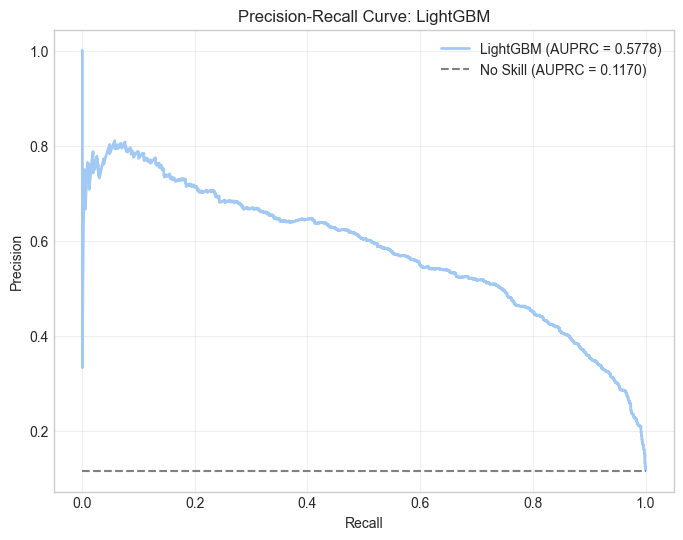

Accuracy: 0.8724
Precision: 0.4720
Recall: 0.7663
F1-score: 0.5842
G-mean: 0.8242
ROC AUC: 0.9177
AUPRC: 0.5778

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.92      9981
           1       0.47      0.77      0.58      1322

    accuracy                           0.87     11303
   macro avg       0.72      0.83      0.75     11303
weighted avg       0.91      0.87      0.88     11303



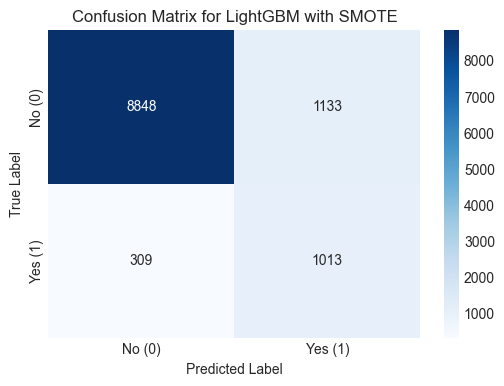


--- Training and Evaluating: CatBoost 


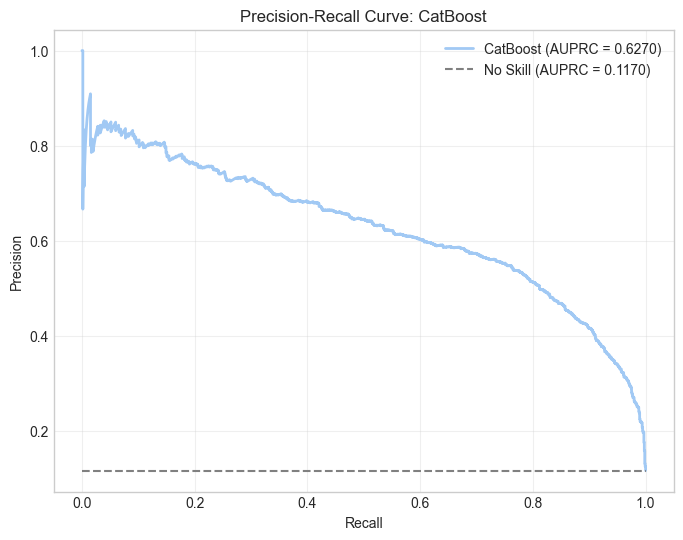

Accuracy: 0.8602
Precision: 0.4495
Recall: 0.8676
F1-score: 0.5922
G-mean: 0.8634
ROC AUC: 0.9327
AUPRC: 0.6270

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9981
           1       0.45      0.87      0.59      1322

    accuracy                           0.86     11303
   macro avg       0.71      0.86      0.75     11303
weighted avg       0.92      0.86      0.88     11303



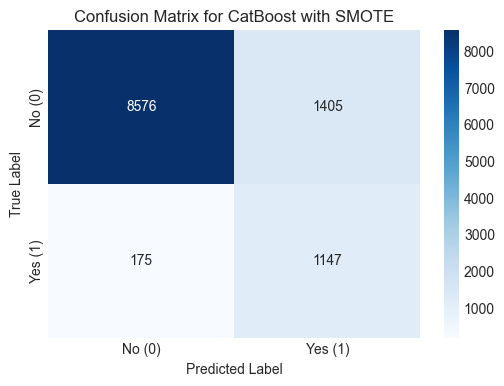


--- Training and Evaluating: XGBoost 


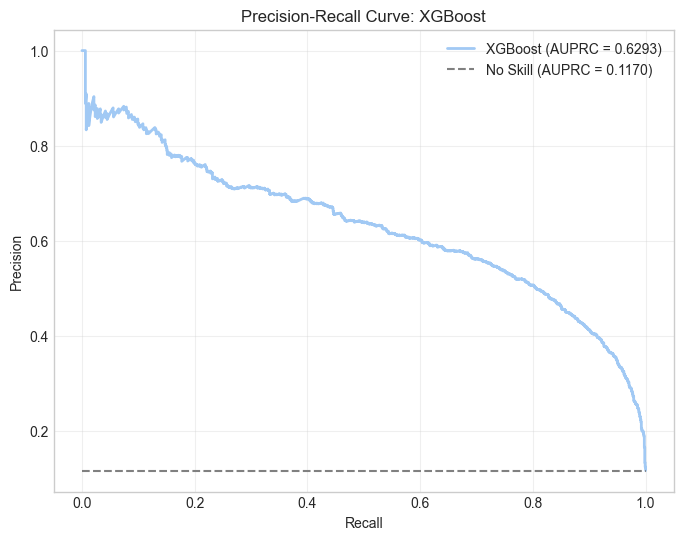

Accuracy: 0.8582
Precision: 0.4454
Recall: 0.8676
F1-score: 0.5887
G-mean: 0.8623
ROC AUC: 0.9322
AUPRC: 0.6293

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      9981
           1       0.45      0.87      0.59      1322

    accuracy                           0.86     11303
   macro avg       0.71      0.86      0.75     11303
weighted avg       0.92      0.86      0.88     11303



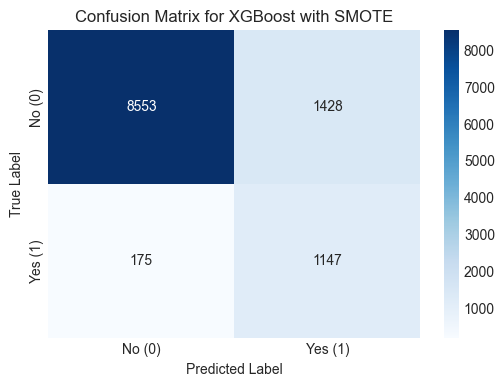

In [81]:
# 修改模型训练循环以使用SMOTE处理后的数据
for model_name, model in models.items():
    print(f"\n--- Training and Evaluating: {model_name} ")
    
    if model_name == "CatBoost":
        # 对于CatBoost，我们直接使用原始数据并传递类别特征的索引
        

        model_fit = model.fit(X_train, y_train, cat_features=categorical_indices)
        # 预处理测试数据
        y_pred = model_fit.predict(X_test)
        y_pred_proba = model_fit.predict_proba(X_test)[:, 1]
    elif model_name == "XGBoost":
        #直接使用原始数据
        # 对训练数据进行预处理(但不应用SMOTE)
        X_train_processed_xgb = fitted_preprocessor.transform(X_train)
        if hasattr(X_train_processed_xgb, "toarray"):
            X_train_processed_xgb = X_train_processed_xgb.toarray()
            
        # 使用处理后的原始数据(不平衡数据)训练XGBoost
        model.fit(X_train_processed_xgb, y_train)
        
        # 对测试数据进行预处理
        X_test_processed = fitted_preprocessor.transform(X_test)
        if hasattr(X_test_processed, "toarray"):
            X_test_processed = X_test_processed.toarray()
            
        # 预测
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    elif model_name == "Naive Bayes":
        # 直接使用SMOTE处理后的数据
        model.fit(X_train_smote, y_train_smote)
        
        # 对测试数据进行预处理
        X_test_processed = fitted_preprocessor.transform(X_test)
        if hasattr(X_test_processed, "toarray"):
            X_test_processed = X_test_processed.toarray()
            
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    else:
        # 其他模型也直接使用SMOTE处理后的数据
        model.fit(X_train_smote, y_train_smote)
        
        # 对测试数据进行预处理
        X_test_processed = fitted_preprocessor.transform(X_test)
        if hasattr(X_test_processed, "toarray"):
            X_test_processed = X_test_processed.toarray()
            
        y_pred = model.predict(X_test_processed)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        else:
            y_pred_proba = None
    
    # 计算ROC AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = np.nan

    # 评估模型
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # 添加G-mean指标
    g_mean = g_mean_score(y_test, y_pred)
    
    # 如果有概率预测,计算ROC AUC和AUPRC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # 添加AUPRC计算
        auprc = plot_pr_curve(y_test, y_pred_proba, model_name)
    else:
        roc_auc = np.nan
        auprc = np.nan

    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC AUC": roc_auc,
        "G-mean": g_mean,     # 添加G-mean到结果字典
        "AUPRC": auprc        # 添加AUPRC到结果字典
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"G-mean: {g_mean:.4f}")  # 打印G-mean
    if not np.isnan(roc_auc):
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"AUPRC: {auprc:.4f}")  # 打印AUPRC
    else:
        print("ROC AUC: Not computable for this model configuration")

    # 分类报告和混淆矩阵部分保持不变
    print("\nClassification Report:")
    classification_reports[model_name] = classification_report(y_test, y_pred, zero_division=0)
    print(classification_reports[model_name])

    plt.figure(figsize=(6, 4))
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_matrices[model_name], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} with SMOTE')
    plt.show()

尝试使用torch的基本MLP进行分类

In [82]:
fitted_preprocessor = preprocessor.fit(X_train)
X_train_processed = fitted_preprocessor.transform(X_train)
if hasattr(X_train_processed, "toarray"):
    X_train_processed_dense = X_train_processed.toarray()
else:
    X_train_processed_dense = X_train_processed
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed_dense, y_train)

# 处理测试数据
X_test_processed = fitted_preprocessor.transform(X_test)
if hasattr(X_test_processed, "toarray"):
    X_test_processed_dense = X_test_processed.toarray()
    print("测试集稀疏矩阵转换为稠密数组")
else:
    X_test_processed_dense = X_test_processed
    print("测试集数据已经是稠密数组")

测试集数据已经是稠密数组


f:\venv\env\sl\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [83]:
# 获取输入特征数量
num_input_features = X_train_processed_dense.shape[1]
print(f"Number of input features for PyTorch NN: {num_input_features}")

Number of input features for PyTorch NN: 45


In [84]:
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.float32).unsqueeze(1)  # BCEWithLogitsLoss需要(batch, 1)
X_test_tensor = torch.tensor(X_test_processed_dense, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [85]:
class BankDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [86]:
batch_size = 64 #可以调整
train_dataset = BankDataset(X_train_tensor, y_train_tensor)
test_dataset = BankDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [87]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128) # 增加神经元数量
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # 添加 Dropout
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(64, 1) # 输出层为1，用于BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        
        x = self.fc3(x) # 没有sigmoid，因为BCEWithLogitsLoss会处理
        return x

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [89]:
model_nn = SimpleNN(num_input_features).to(device)
criterion_nn = nn.BCEWithLogitsLoss() # 包含Sigmoid，更稳定
optimizer_nn = optim.Adam(model_nn.parameters(), lr=0.001) # 学习率可以调整
scheduler_nn = optim.lr_scheduler.CosineAnnealingLR(optimizer_nn, T_max=50, eta_min=0)



Starting PyTorch NN training for 30 epochs...
Epoch [5/30], Train Loss: 0.2603, Test Loss: 0.3233, Test Accuracy: 0.8466, Test F1-score: 0.5637
Epoch [10/30], Train Loss: 0.2291, Test Loss: 0.2969, Test Accuracy: 0.8716, Test F1-score: 0.5979
Epoch [15/30], Train Loss: 0.2091, Test Loss: 0.2970, Test Accuracy: 0.8804, Test F1-score: 0.6026
Epoch [20/30], Train Loss: 0.1964, Test Loss: 0.3024, Test Accuracy: 0.8772, Test F1-score: 0.5967
Epoch [25/30], Train Loss: 0.1858, Test Loss: 0.3191, Test Accuracy: 0.8756, Test F1-score: 0.5946
Epoch [30/30], Train Loss: 0.1789, Test Loss: 0.3098, Test Accuracy: 0.8774, Test F1-score: 0.5954


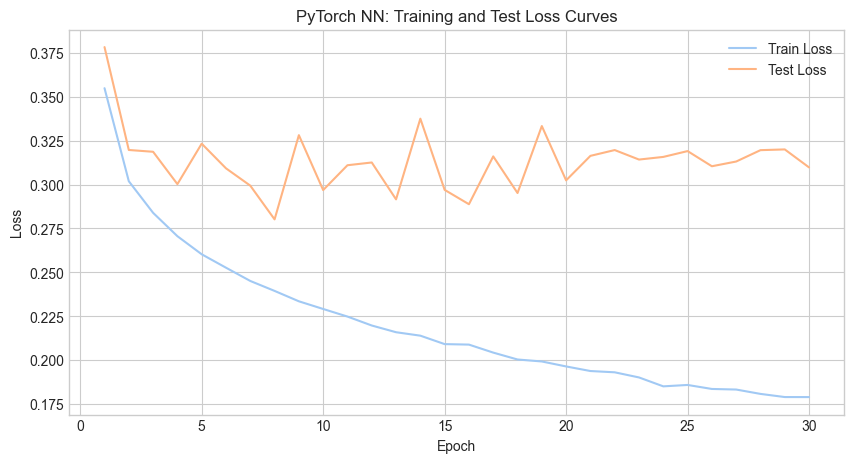

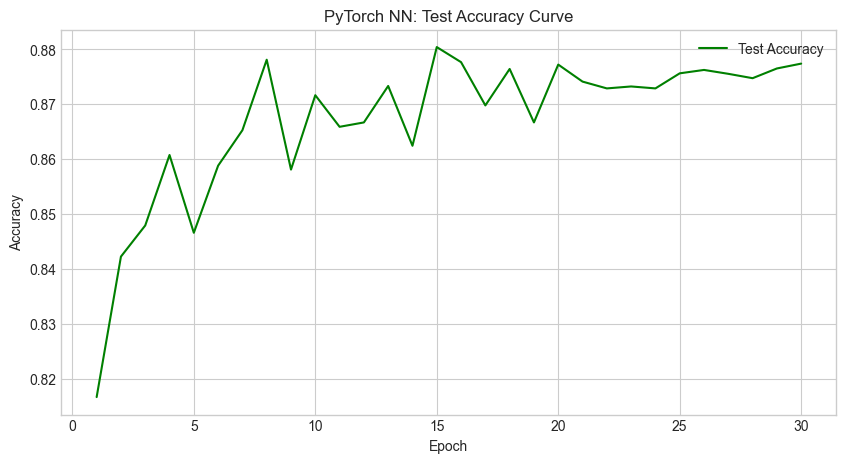

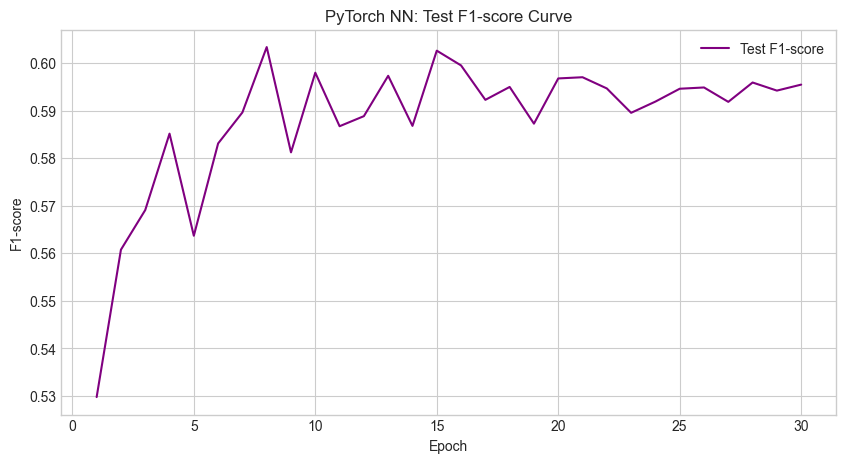

In [90]:
num_epochs = 30 # 可以调整
train_losses = [] # 记录每个epoch的训练损失
test_losses = []  # 记录每个epoch的测试损失
test_accuracies = [] # 记录每个epoch的测试准确率
test_f1_scores = []   # 记录每个epoch的测试F1-score

best_test_f1 = -1.0    # 用于追踪最佳测试F1-score
best_epoch = -1
# best_model_state_dict = None # 或者直接保存到文件

# 定义最佳模型保存路径
BEST_MODEL_PATH = 'best_model_nn.pth'

print(f"\nStarting PyTorch NN training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model_nn.train() # 设置为训练模式
    current_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer_nn.zero_grad()
        outputs = model_nn(data)
        loss = criterion_nn(outputs, targets)
        loss.backward()
        optimizer_nn.step()
        
        current_train_loss += loss.item() * data.size(0)

    avg_train_loss = current_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 在每个 epoch 结束后进行测试集上的评估
    model_nn.eval() # 设置为评估模式
    current_test_loss = 0.0
    
    epoch_all_targets = []
    epoch_all_predictions = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets_cpu = targets.cpu().numpy().flatten() # 先转到CPU并展平
            epoch_all_targets.extend(targets_cpu)

            targets = targets.to(device) # targets 给loss用
            
            outputs_logits = model_nn(data)
            loss = criterion_nn(outputs_logits, targets)
            current_test_loss += loss.item() * data.size(0)

            probabilities = torch.sigmoid(outputs_logits)
            predicted_cpu = (probabilities > 0.5).float().cpu().numpy().flatten() # 转到CPU并展平
            epoch_all_predictions.extend(predicted_cpu)

    avg_test_loss = current_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    
    # 计算当前epoch的测试准确率和F1-score
    # 确保 epoch_all_targets 和 epoch_all_predictions 是 numpy arrays
    np_epoch_all_targets = np.array(epoch_all_targets)
    np_epoch_all_predictions = np.array(epoch_all_predictions)

    current_test_accuracy = accuracy_score(np_epoch_all_targets, np_epoch_all_predictions)
    current_test_f1 = f1_score(np_epoch_all_targets, np_epoch_all_predictions, zero_division=0)
    
    test_accuracies.append(current_test_accuracy)
    test_f1_scores.append(current_test_f1)

    #调度器更新
    scheduler_nn.step() # 更新学习率

    # 检查是否是最佳模型 (基于F1-score)
    if current_test_f1 > best_test_f1:
        best_test_f1 = current_test_f1
        best_epoch = epoch + 1
        torch.save(model_nn.state_dict(), BEST_MODEL_PATH) # 保存最佳模型的状态字典
        # print(f"*** Epoch {epoch+1}: New best model saved with Test F1-score: {best_test_f1:.4f} ***") # 每次保存都打印

    # 每5个epoch或者最后一个epoch输出一次信息
    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {current_test_accuracy:.4f}, Test F1-score: {current_test_f1:.4f}")
        if best_epoch == (epoch + 1): # 如果当前epoch是最佳的，也提示一下
             print(f"    (This epoch is currently the best model based on F1-score: {best_test_f1:.4f})")


# 7.5.1. 绘制训练和测试损失曲线 (保持不变)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch NN: Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# (可选) 绘制测试准确率曲线 (保持不变)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PyTorch NN: Test Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 新增: 绘制测试F1-score曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_f1_scores, label='Test F1-score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('PyTorch NN: Test F1-score Curve')
plt.legend()
plt.grid(True)
plt.show()


In [91]:
# 7.6. 最终评估 PyTorch 模型 (加载在训练过程中保存的最佳模型)
print(f"\nLoading best model (from epoch {best_epoch} with Test F1-score: {best_test_f1:.4f}) for final evaluation...")
if os.path.exists(BEST_MODEL_PATH):
    model_nn.load_state_dict(torch.load(BEST_MODEL_PATH)) # 加载最佳模型的状态
else:
    print(f"Warning: Best model file '{BEST_MODEL_PATH}' not found. Evaluating the model from the last epoch.")
    # 如果没有找到最佳模型文件，将使用训练结束时的模型状态进行评估


Loading best model (from epoch 8 with Test F1-score: 0.6033) for final evaluation...


In [92]:
# 7.6. 评估 PyTorch 模型
model_nn.eval() # 设置为评估模式
all_targets_nn = []
all_predictions_nn = []
all_probabilities_nn = []

with torch.no_grad(): # 在评估时不计算梯度
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        outputs_logits = model_nn(data)
        
        # 计算概率 (通过sigmoid) 和预测类别
        probabilities = torch.sigmoid(outputs_logits)
        predicted = (probabilities > 0.5).float() #阈值为0.5

        all_targets_nn.extend(targets.cpu().numpy())
        all_predictions_nn.extend(predicted.cpu().numpy())
        all_probabilities_nn.extend(probabilities.cpu().numpy())
all_targets_nn = np.array(all_targets_nn).flatten() # 确保是一维的
all_predictions_nn = np.array(all_predictions_nn).flatten()
all_probabilities_nn = np.array(all_probabilities_nn).flatten()



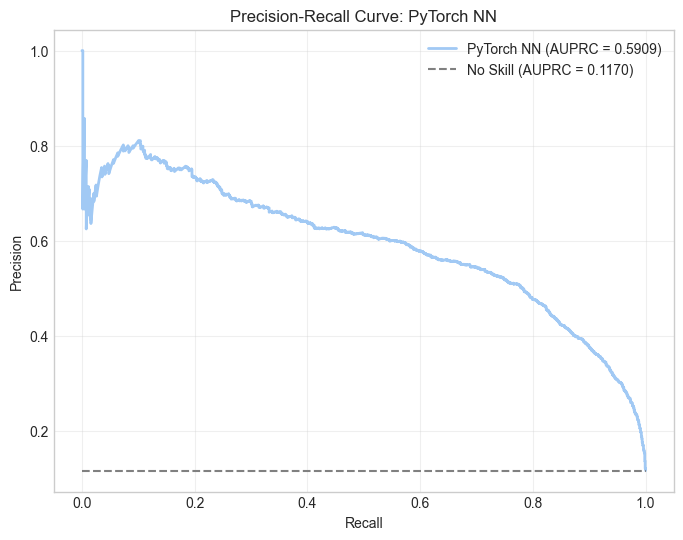

In [93]:
accuracy_nn = accuracy_score(all_targets_nn, all_predictions_nn)
precision_nn = precision_score(all_targets_nn, all_predictions_nn, zero_division=0)
recall_nn = recall_score(all_targets_nn, all_predictions_nn, zero_division=0)
f1_nn = f1_score(all_targets_nn, all_predictions_nn, zero_division=0)
roc_auc_nn = roc_auc_score(all_targets_nn, all_probabilities_nn) # 使用概率

# 添加G-mean和AUPRC计算
g_mean_nn = g_mean_score(all_targets_nn, all_predictions_nn)
auprc_nn = plot_pr_curve(all_targets_nn, all_probabilities_nn, "PyTorch NN")


In [94]:
# 更新结果字典
results["PyTorch NN"] = {
    "Accuracy": accuracy_nn,
    "Precision": precision_nn,
    "Recall": recall_nn,
    "F1-score": f1_nn,
    "ROC AUC": roc_auc_nn,
    "G-mean": g_mean_nn,     # 添加G-mean
    "AUPRC": auprc_nn        # 添加AUPRC
}
print(f"\nPyTorch NN Test Metrics:")
print(f"Accuracy: {accuracy_nn:.4f}, Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}")
print(f"F1-score: {f1_nn:.4f}, ROC AUC: {roc_auc_nn:.4f}")
print(f"G-mean: {g_mean_nn:.4f}, AUPRC: {auprc_nn:.4f}")  # 打印新添加的指标


PyTorch NN Test Metrics:
Accuracy: 0.8781, Precision: 0.4870, Recall: 0.7927
F1-score: 0.6033, ROC AUC: 0.9229
G-mean: 0.8397, AUPRC: 0.5909


In [95]:
# 方法比较
results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False) # 将结果转换为DataFrame并按ROC AUC排序
print("\n\n--- Model Comparison Summary ---") # 模型比较摘要
print(results_df)



--- Model Comparison Summary ---
                                     Accuracy  Precision    Recall  F1-score  \
CatBoost                             0.860214   0.449451  0.867625  0.592153   
XGBoost                              0.858179   0.445437  0.867625  0.588658   
Random Forest                        0.903123   0.593109  0.546899  0.569067   
PyTorch NN                           0.878085   0.486989  0.792738  0.603339   
LightGBM                             0.872423   0.472041  0.766263  0.584198   
Support Vector Machine (RBF Kernel)  0.859860   0.445142  0.804085  0.573046   
Logistic Regression                  0.847474   0.420928  0.809380  0.553830   
Naive Bayes                          0.813501   0.331764  0.586233  0.423729   
Decision Tree                        0.863665   0.431262  0.519667  0.471355   

                                      ROC AUC    G-mean     AUPRC  
CatBoost                             0.932699  0.863418  0.627050  
XGBoost                     

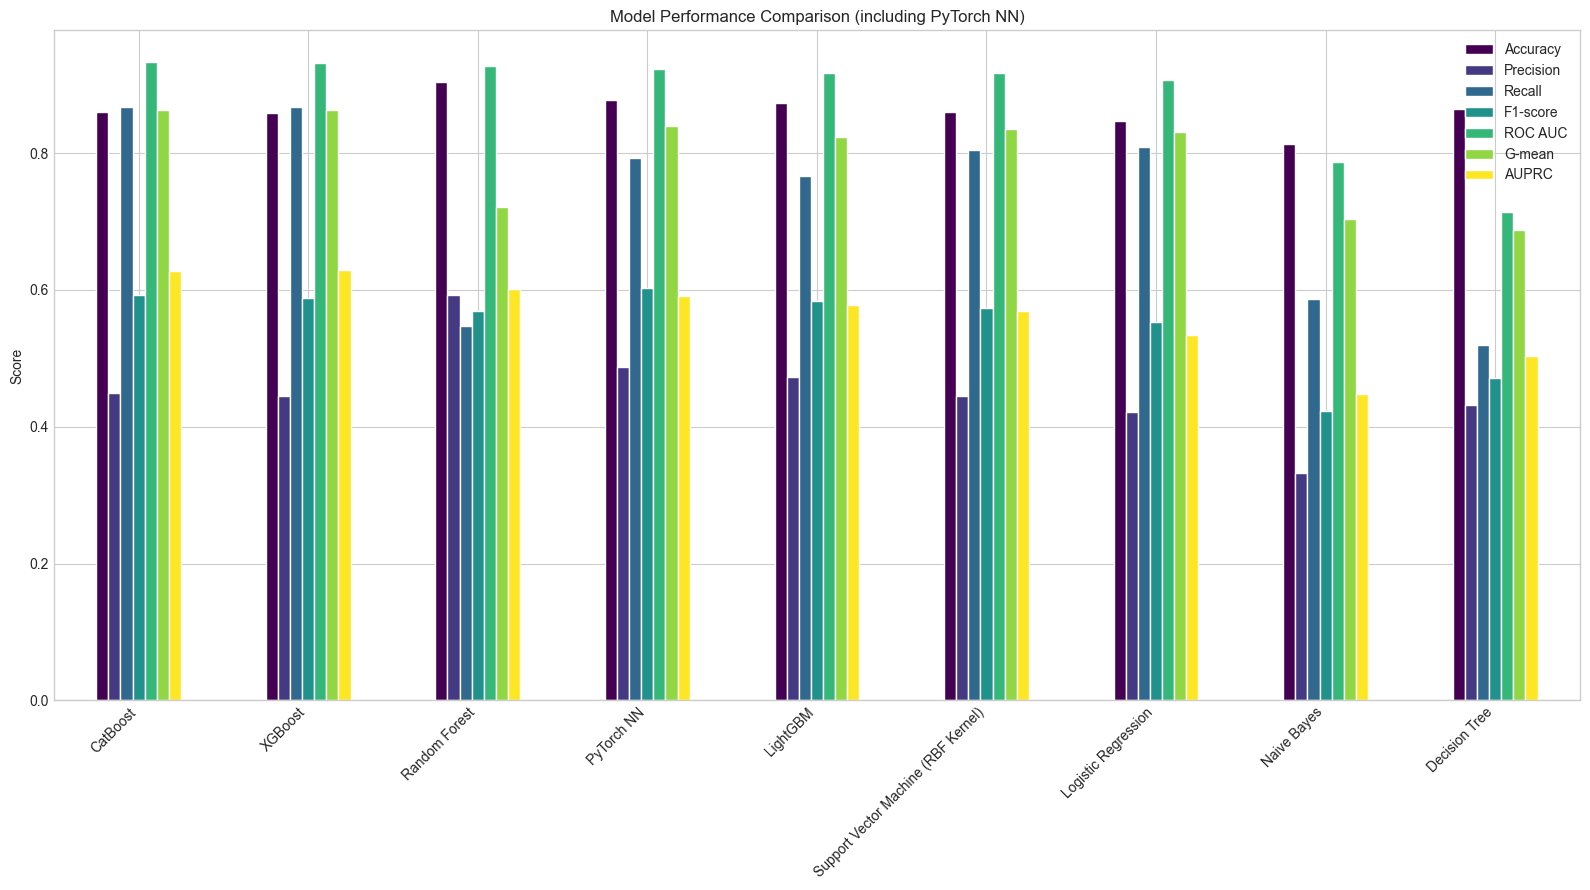

In [96]:
# 绘制结果以便于比较
results_df.plot(kind='bar', figsize=(16, 9), colormap='viridis') # 调整了图形大小
plt.title('Model Performance Comparison (including PyTorch NN)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best') # 调整legend位置
plt.tight_layout()
plt.show()


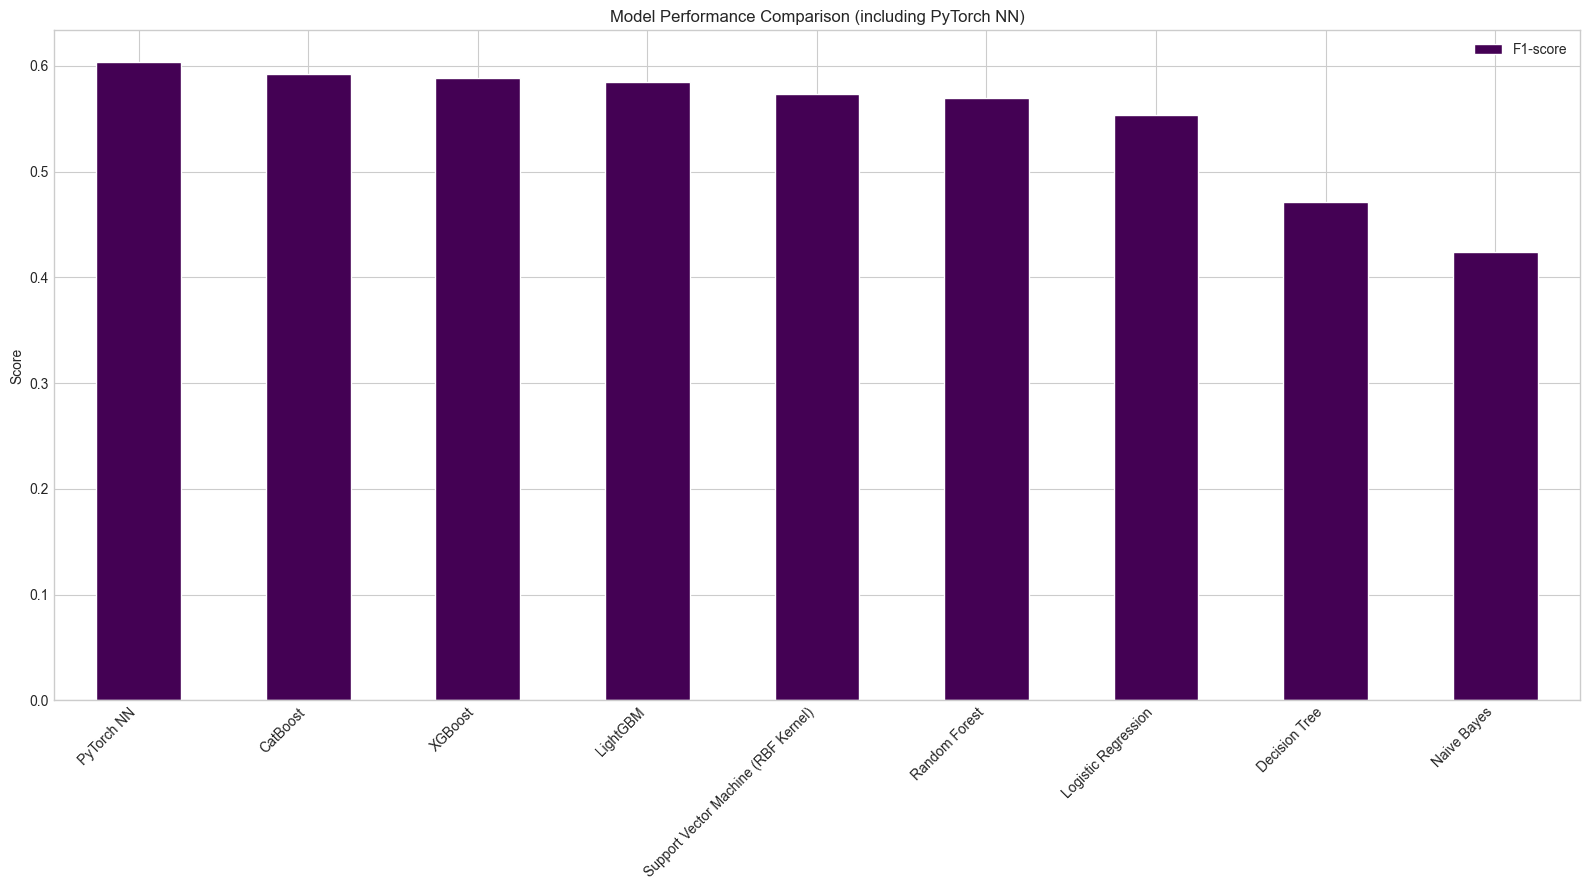

In [97]:
#只绘制F1-score列
results_df = results_df.sort_values(by="F1-score", ascending=False) # 按照Recall降序排序

results_df["F1-score"].plot(kind='bar', figsize=(16, 9), colormap='viridis') # 调整了图形大小
plt.title('Model Performance Comparison (including PyTorch NN)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best') # 调整legend位置
plt.tight_layout()
plt.show()

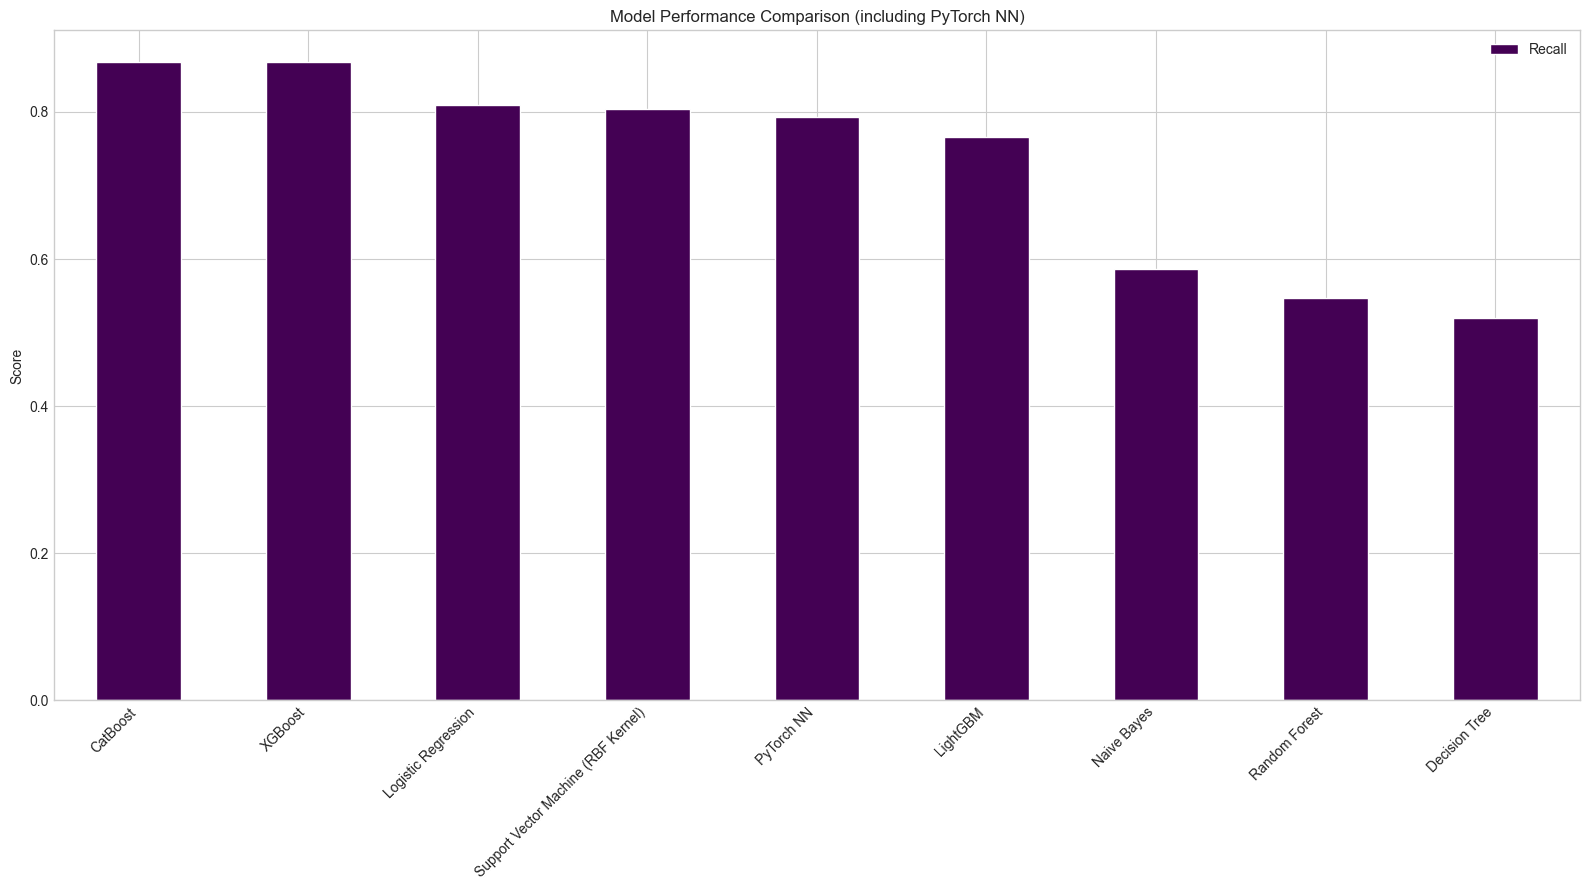

In [98]:
#只绘制Recall列,按照降序排序
results_df = results_df.sort_values(by="Recall", ascending=False) # 按照Recall降序排序
results_df["Recall"].plot(kind='bar', figsize=(16, 9), colormap='viridis') # 调整了图形大小

plt.title('Model Performance Comparison (including PyTorch NN)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best') # 调整legend位置
plt.tight_layout()
plt.show()

### 尝试使用分类投票器


F1-score指标：PyTorch NN、CatBoost、XGBoost表现最好
Recall指标：CatBoost、XGBoost、Logistic Regression表现最好
综合考虑，我建议选择以下3个模型组成投票分类器：

CatBoost - 在Recall和F1-score上表现都很好
XGBoost - 也在两个指标上都表现优异
PyTorch NN - 在F1-score上表现最好，提供不同类型的模型多样性
这三种模型具有不同的算法机制(基于树的集成、神经网络)，能够提供多样化的预测视角。

In [99]:
print("\n--- 创建投票分类器 ---")

# 根据性能选择的三个最佳模型
selected_models = ["CatBoost", "XGBoost", "PyTorch NN"]
print(f"选择的投票分类器模型: {selected_models}")

# 由于PyTorch NN不符合sklearn的接口要求，我们需要创建一个包装类
class PyTorchWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.classes_ = np.array([0, 1])  # 二分类问题
        
    def predict(self, X):
        # 转换为Tensor并预测
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).cpu().numpy().astype(int).flatten()
        return predictions
    
    def predict_proba(self, X):
        # 返回每个类别的概率
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()
            # 对于二分类，需要返回形状为(n_samples, 2)的数组
            return np.column_stack((1 - probabilities, probabilities))



--- 创建投票分类器 ---
选择的投票分类器模型: ['CatBoost', 'XGBoost', 'PyTorch NN']


In [100]:

# 创建需要的模型实例
# 对于已经训练过的模型，我们直接使用
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='AUC',
    leaf_estimation_method='Newton',
    verbose=0,
    auto_class_weights='Balanced',
    thread_count=-1,
    task_type='CPU',
    bootstrap_type='Bayesian',
    bagging_temperature=1,
    max_ctr_complexity=2,
    grow_policy='Lossguide',
    min_data_in_leaf=10,
    max_leaves=64
)

xgboost_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=imbalance_ratio,
    seed=42,
    tree_method='hist'
)

# 训练模型(CatBoost)
print("训练CatBoost模型...")
catboost_model.fit(X_train, y_train, cat_features=categorical_indices)

# 训练模型(XGBoost)
print("训练XGBoost模型...")
X_train_processed_xgb = fitted_preprocessor.transform(X_train)
if hasattr(X_train_processed_xgb, "toarray"):
    X_train_processed_xgb = X_train_processed_xgb.toarray()
xgboost_model.fit(X_train_processed_xgb, y_train)

# PyTorch模型已经训练过了，使用之前训练好的最佳模型
# 确保已加载最佳模型
if not os.path.exists(BEST_MODEL_PATH):
    print(f"警告: PyTorch模型文件 '{BEST_MODEL_PATH}' 未找到，请确保已经训练并保存模型。")
else:
    model_nn.load_state_dict(torch.load(BEST_MODEL_PATH))
    
# 创建PyTorch模型的包装类
pytorch_wrapper = PyTorchWrapper(model_nn, device)



训练CatBoost模型...
训练XGBoost模型...



--- 使用投票分类器进行预测 ---
CatBoost预测完成
XGBoost预测完成
PyTorch预测完成


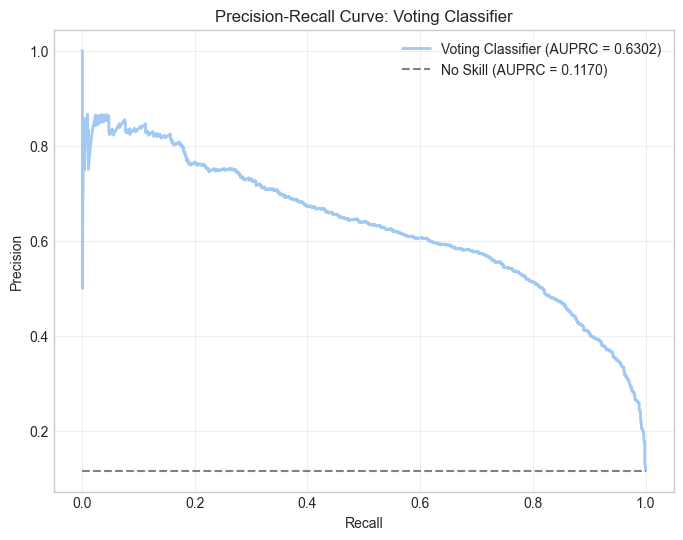


--- 投票分类器评估结果 ---
Accuracy: 0.8710
Precision: 0.4714
Recall: 0.8472
F1-score: 0.6057
ROC AUC: 0.9334
G-mean: 0.8606
AUPRC: 0.6302

分类报告:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9981
           1       0.47      0.85      0.61      1322

    accuracy                           0.87     11303
   macro avg       0.72      0.86      0.76     11303
weighted avg       0.92      0.87      0.89     11303



In [101]:
# 创建并配置投票分类器
# 对于soft voting，我们会使用预测的概率
estimators = [
    ('CatBoost', catboost_model),
    ('XGBoost', xgboost_model),
    ('PyTorch', pytorch_wrapper)
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

print("\n--- 使用投票分类器进行预测 ---")
# 由于不同模型需要不同的数据预处理，我们需要为每个模型单独预测，然后手动组合结果

# 对测试数据进行预测
catboost_proba = catboost_model.predict_proba(X_test)[:, 1]
print("CatBoost预测完成")

X_test_processed = fitted_preprocessor.transform(X_test)
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()
xgboost_proba = xgboost_model.predict_proba(X_test_processed)[:, 1]
print("XGBoost预测完成")

model_nn.eval()
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
with torch.no_grad():
    outputs = model_nn(X_test_tensor)
    pytorch_proba = torch.sigmoid(outputs).cpu().numpy().flatten()
print("PyTorch预测完成")

# 组合预测概率(软投票)
ensemble_proba = (catboost_proba + xgboost_proba + pytorch_proba) / 3
ensemble_predictions = (ensemble_proba > 0.5).astype(int)

# 评估投票分类器
accuracy_voting = accuracy_score(y_test, ensemble_predictions)
precision_voting = precision_score(y_test, ensemble_predictions, zero_division=0)
recall_voting = recall_score(y_test, ensemble_predictions, zero_division=0)
f1_voting = f1_score(y_test, ensemble_predictions, zero_division=0)
roc_auc_voting = roc_auc_score(y_test, ensemble_proba)

# 添加G-mean和AUPRC
g_mean_voting = g_mean_score(y_test, ensemble_predictions)
auprc_voting = plot_pr_curve(y_test, ensemble_proba, "Voting Classifier")


# 保存结果
results["Voting Classifier"] = {
    "Accuracy": accuracy_voting,
    "Precision": precision_voting,
    "Recall": recall_voting,
    "F1-score": f1_voting,
    "ROC AUC": roc_auc_voting,
    "G-mean": g_mean_voting,  # 添加G-mean
    "AUPRC": auprc_voting     # 添加AUPRC
}

print("\n--- 投票分类器评估结果 ---")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1-score: {f1_voting:.4f}")
print(f"ROC AUC: {roc_auc_voting:.4f}")
print(f"G-mean: {g_mean_voting:.4f}")  # 打印G-mean
print(f"AUPRC: {auprc_voting:.4f}")    # 打印AUPRC
# 打印分类报告
print("\n分类报告:")
print(classification_report(y_test, ensemble_predictions, zero_division=0))




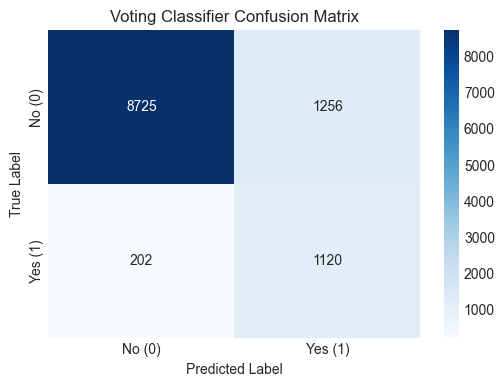



--- Updated Model Comparison Summary (Including Voting Classifier) ---
                                     Accuracy  Precision    Recall  F1-score  \
Voting Classifier                    0.871008   0.471380  0.847201  0.605733   
CatBoost                             0.860214   0.449451  0.867625  0.592153   
XGBoost                              0.858179   0.445437  0.867625  0.588658   
Random Forest                        0.903123   0.593109  0.546899  0.569067   
PyTorch NN                           0.878085   0.486989  0.792738  0.603339   
LightGBM                             0.872423   0.472041  0.766263  0.584198   
Support Vector Machine (RBF Kernel)  0.859860   0.445142  0.804085  0.573046   
Logistic Regression                  0.847474   0.420928  0.809380  0.553830   
Naive Bayes                          0.813501   0.331764  0.586233  0.423729   
Decision Tree                        0.863665   0.431262  0.519667  0.471355   

                                      ROC AUC 

<Figure size 1600x900 with 0 Axes>

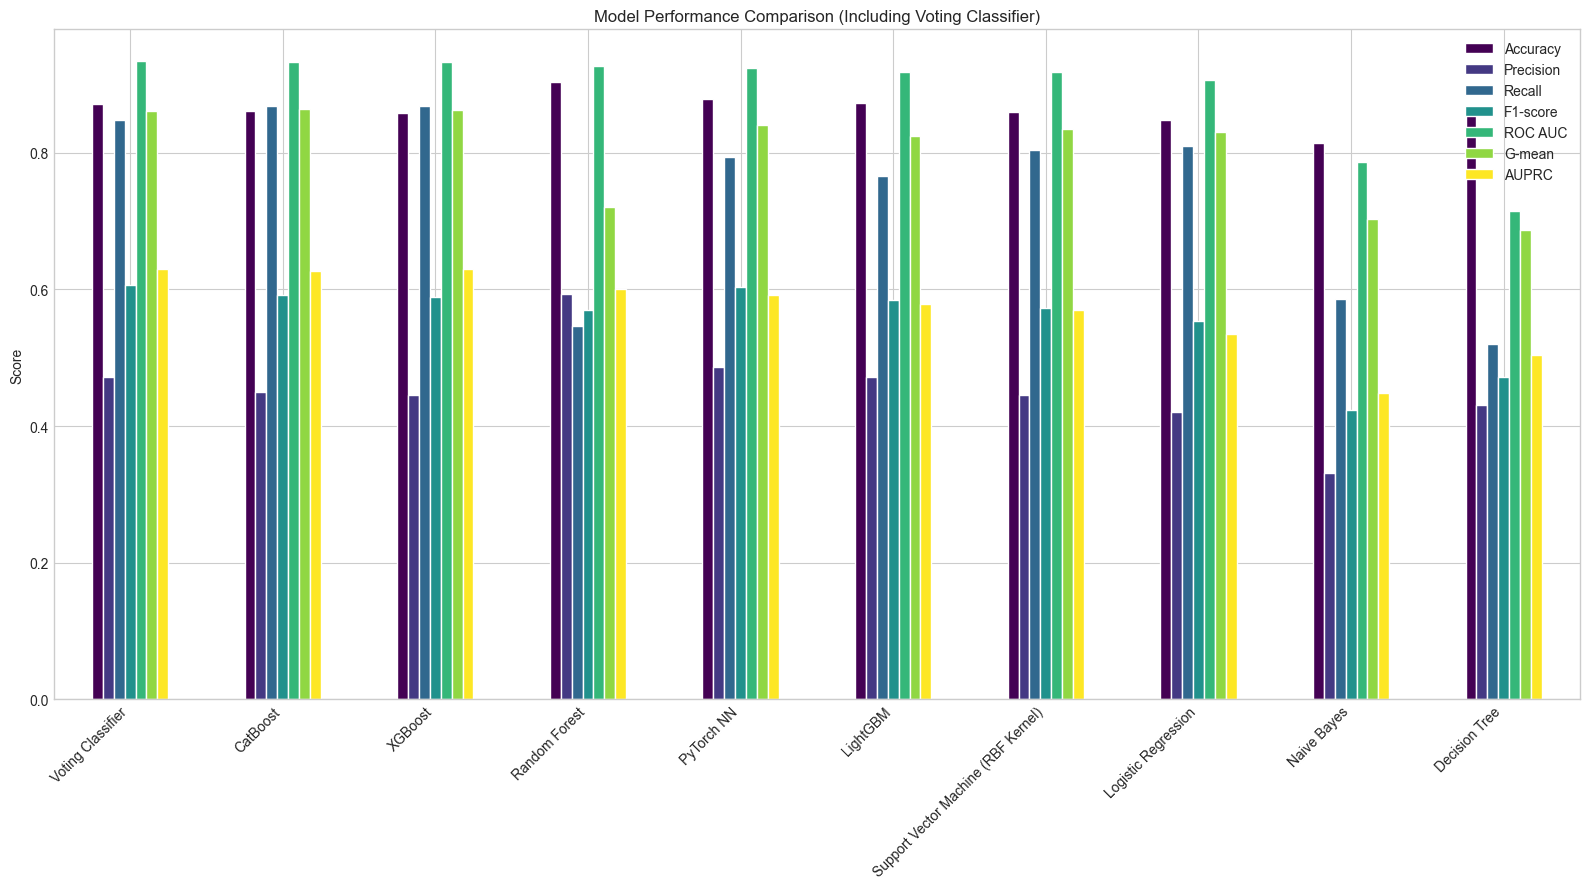

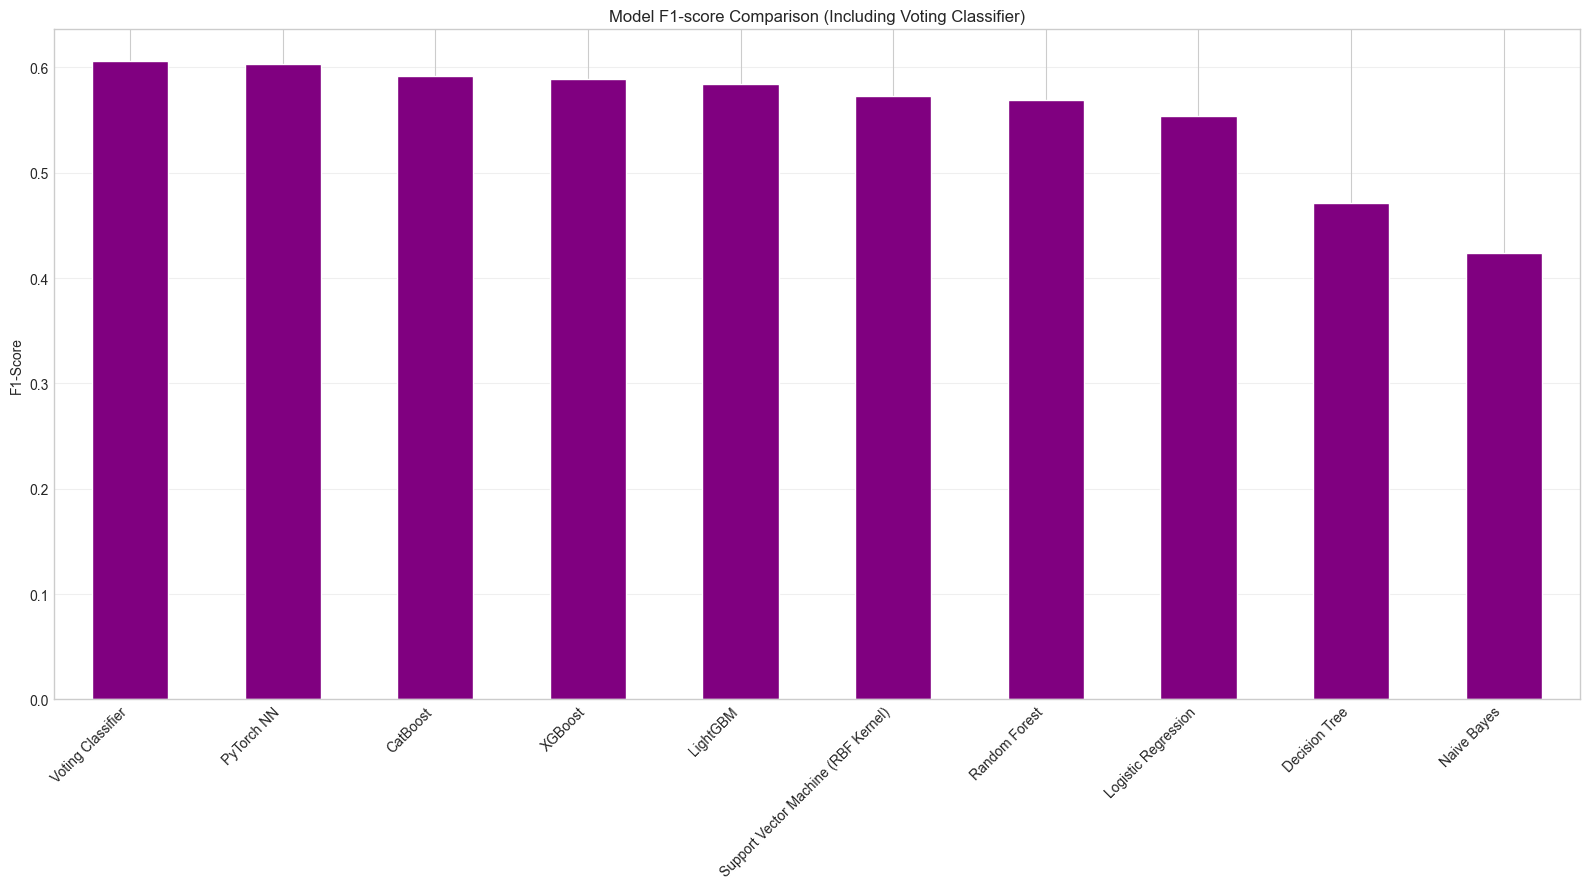

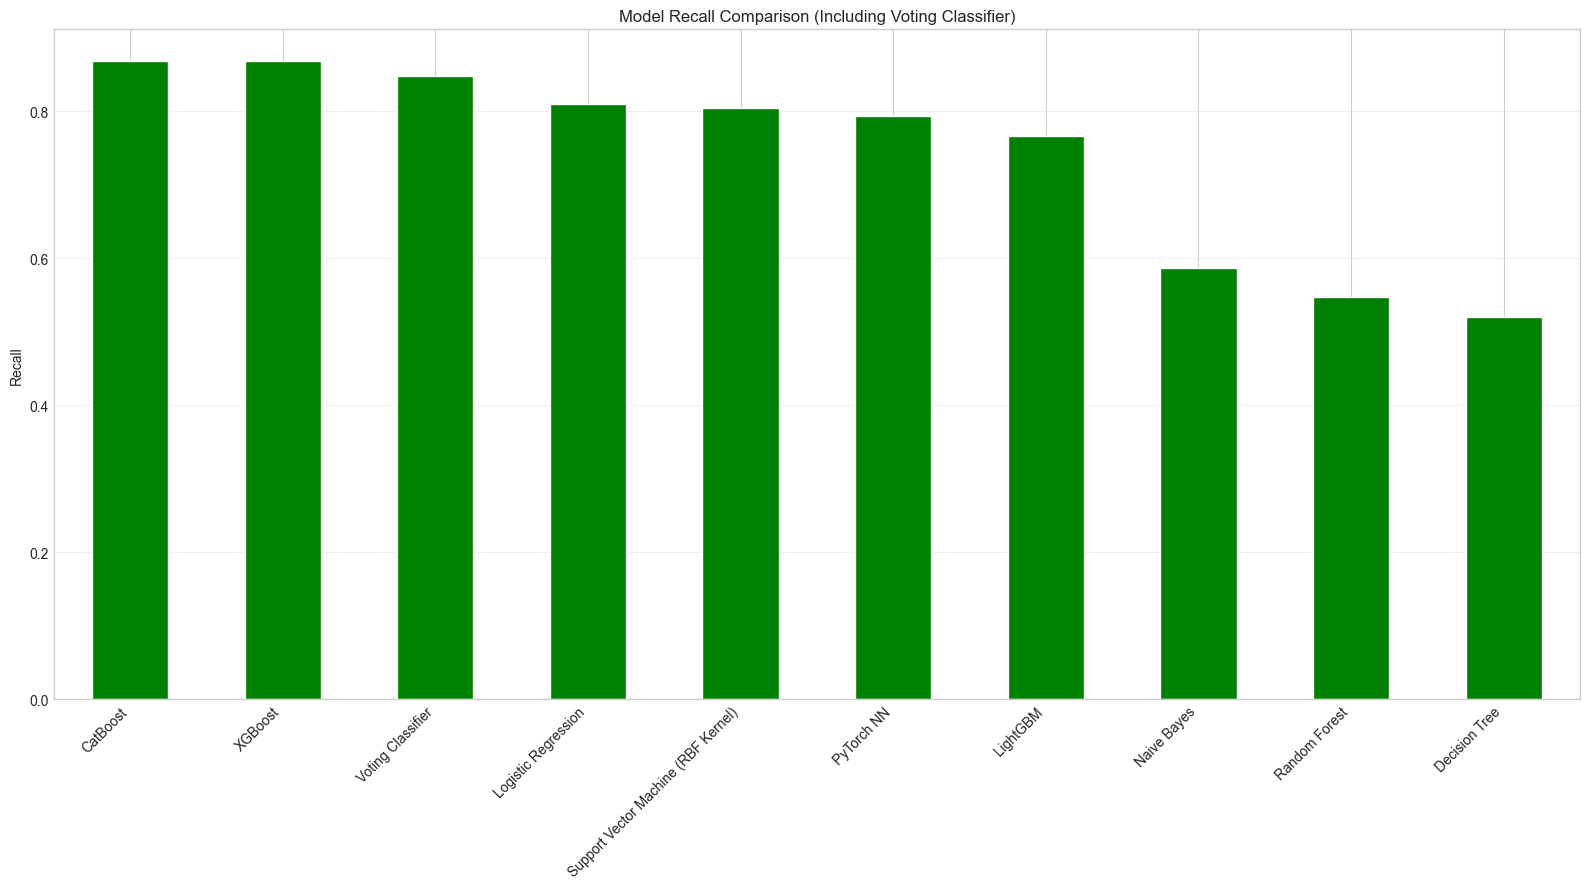

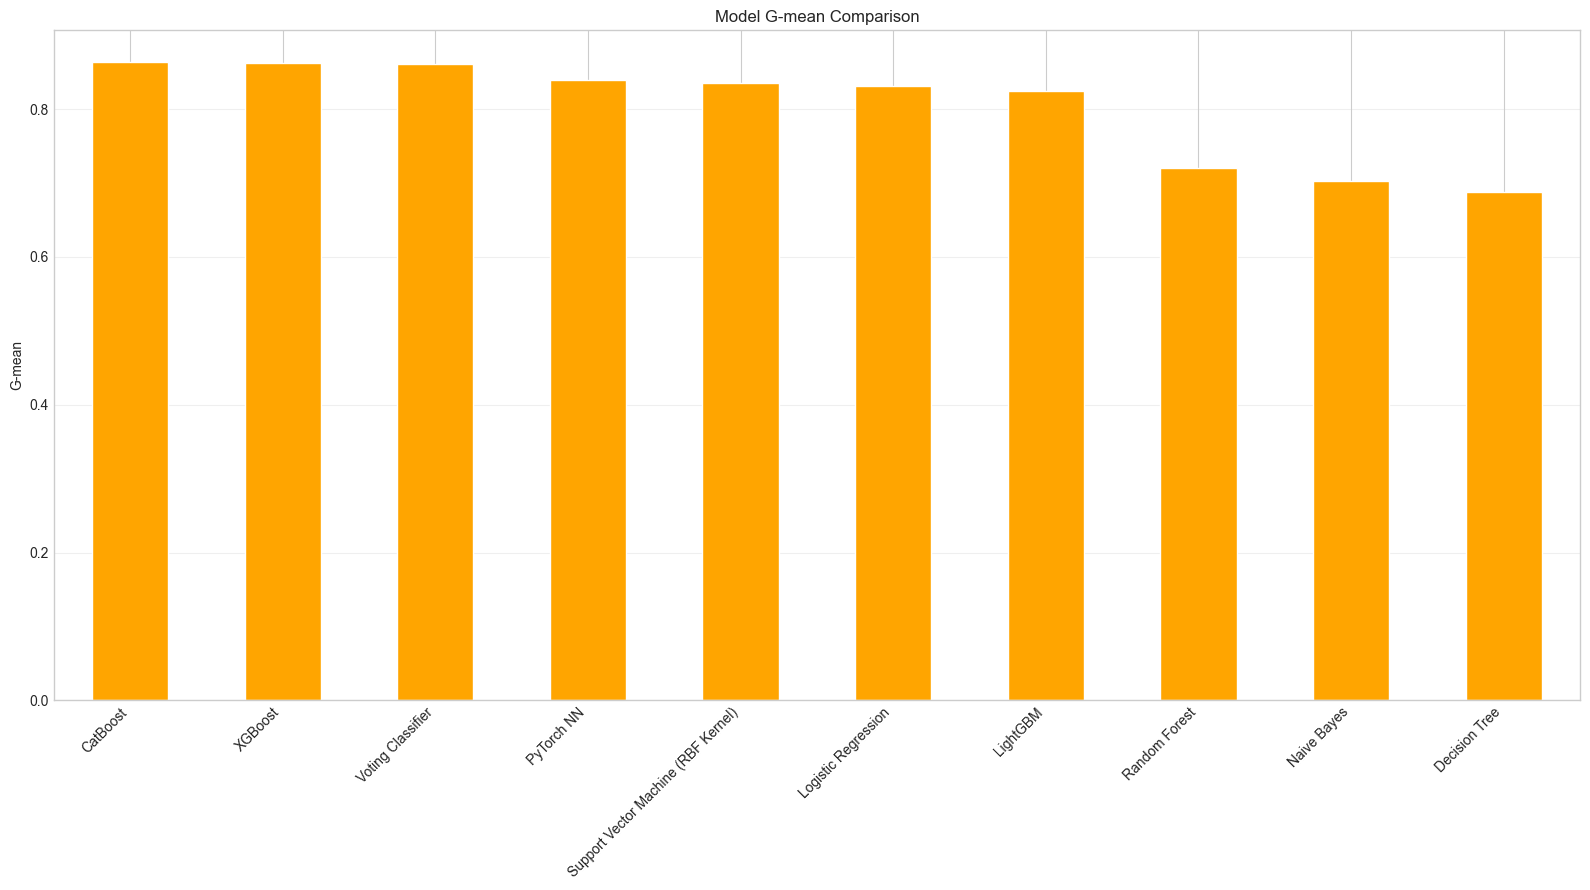

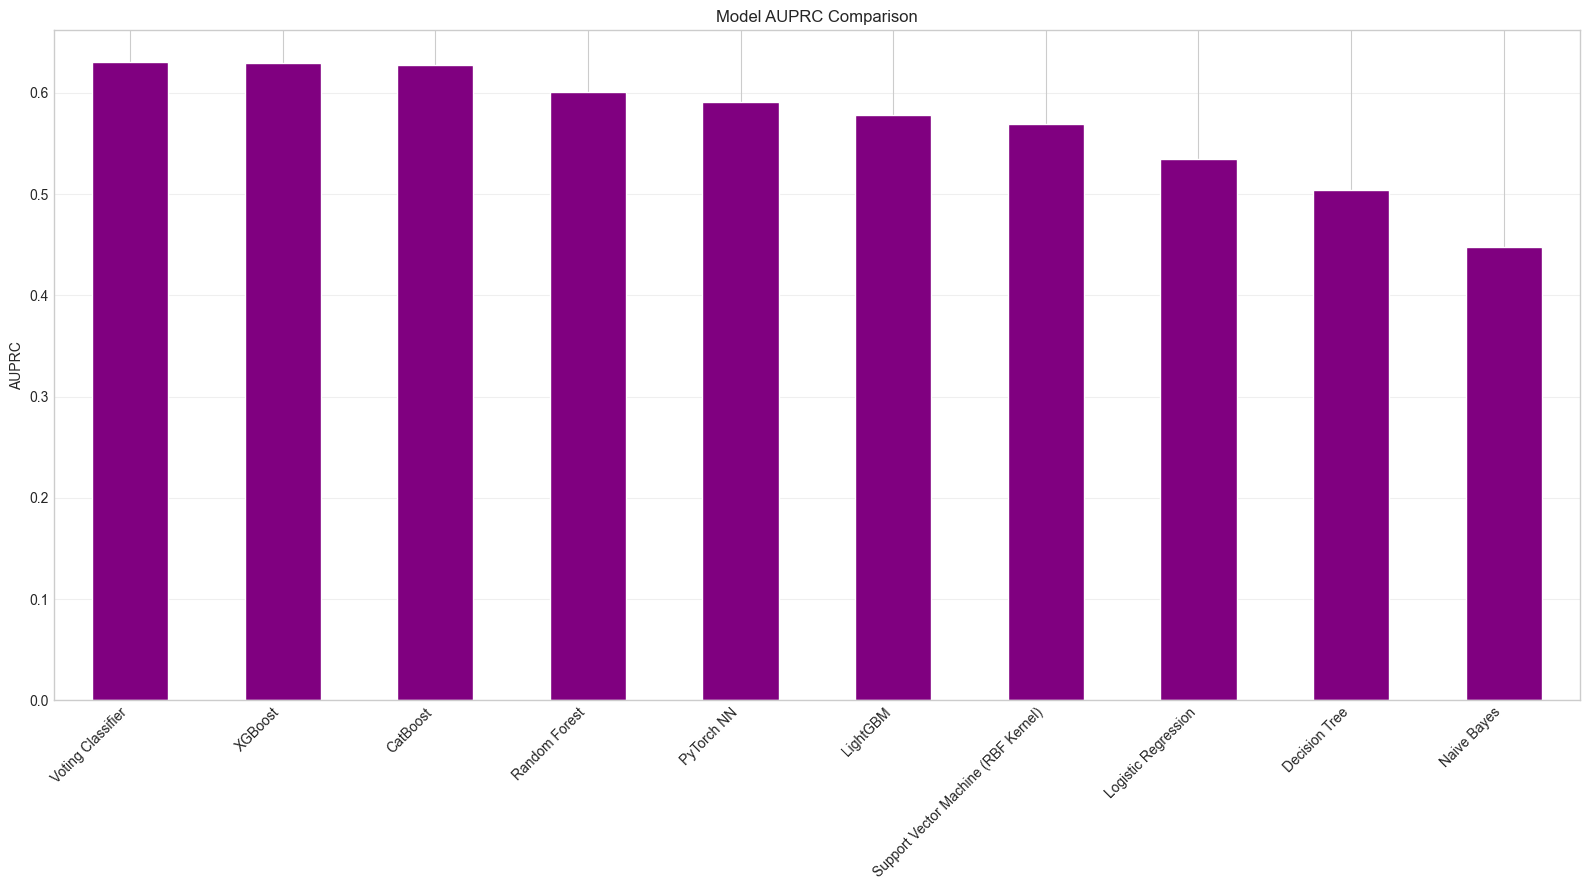

In [102]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
cm_voting = confusion_matrix(y_test, ensemble_predictions)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Voting Classifier Confusion Matrix')
plt.show()

# Update results DataFrame and display comparison
results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
print("\n\n--- Updated Model Comparison Summary (Including Voting Classifier) ---")
print(results_df)

# Plot updated results comparison
plt.figure(figsize=(16, 9))
results_df.plot(kind='bar', figsize=(16, 9), colormap='viridis')
plt.title('Model Performance Comparison (Including Voting Classifier)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot F1-score comparison only
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="F1-score", ascending=False)
results_df["F1-score"].plot(kind='bar', figsize=(16, 9), color='purple')
plt.title('Model F1-score Comparison (Including Voting Classifier)')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Recall comparison only
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="Recall", ascending=False)
results_df["Recall"].plot(kind='bar', figsize=(16, 9), color='green')
plt.title('Model Recall Comparison (Including Voting Classifier)')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 可视化G-mean指标比较
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="G-mean", ascending=False)
results_df["G-mean"].plot(kind='bar', figsize=(16, 9), color='orange')
plt.title('Model G-mean Comparison')
plt.ylabel('G-mean')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 可视化AUPRC指标比较
plt.figure(figsize=(16, 9))
results_df = results_df.sort_values(by="AUPRC", ascending=False)
results_df["AUPRC"].plot(kind='bar', figsize=(16, 9), color='purple')
plt.title('Model AUPRC Comparison')
plt.ylabel('AUPRC')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 收集不同的数据绘制最终方法对比图

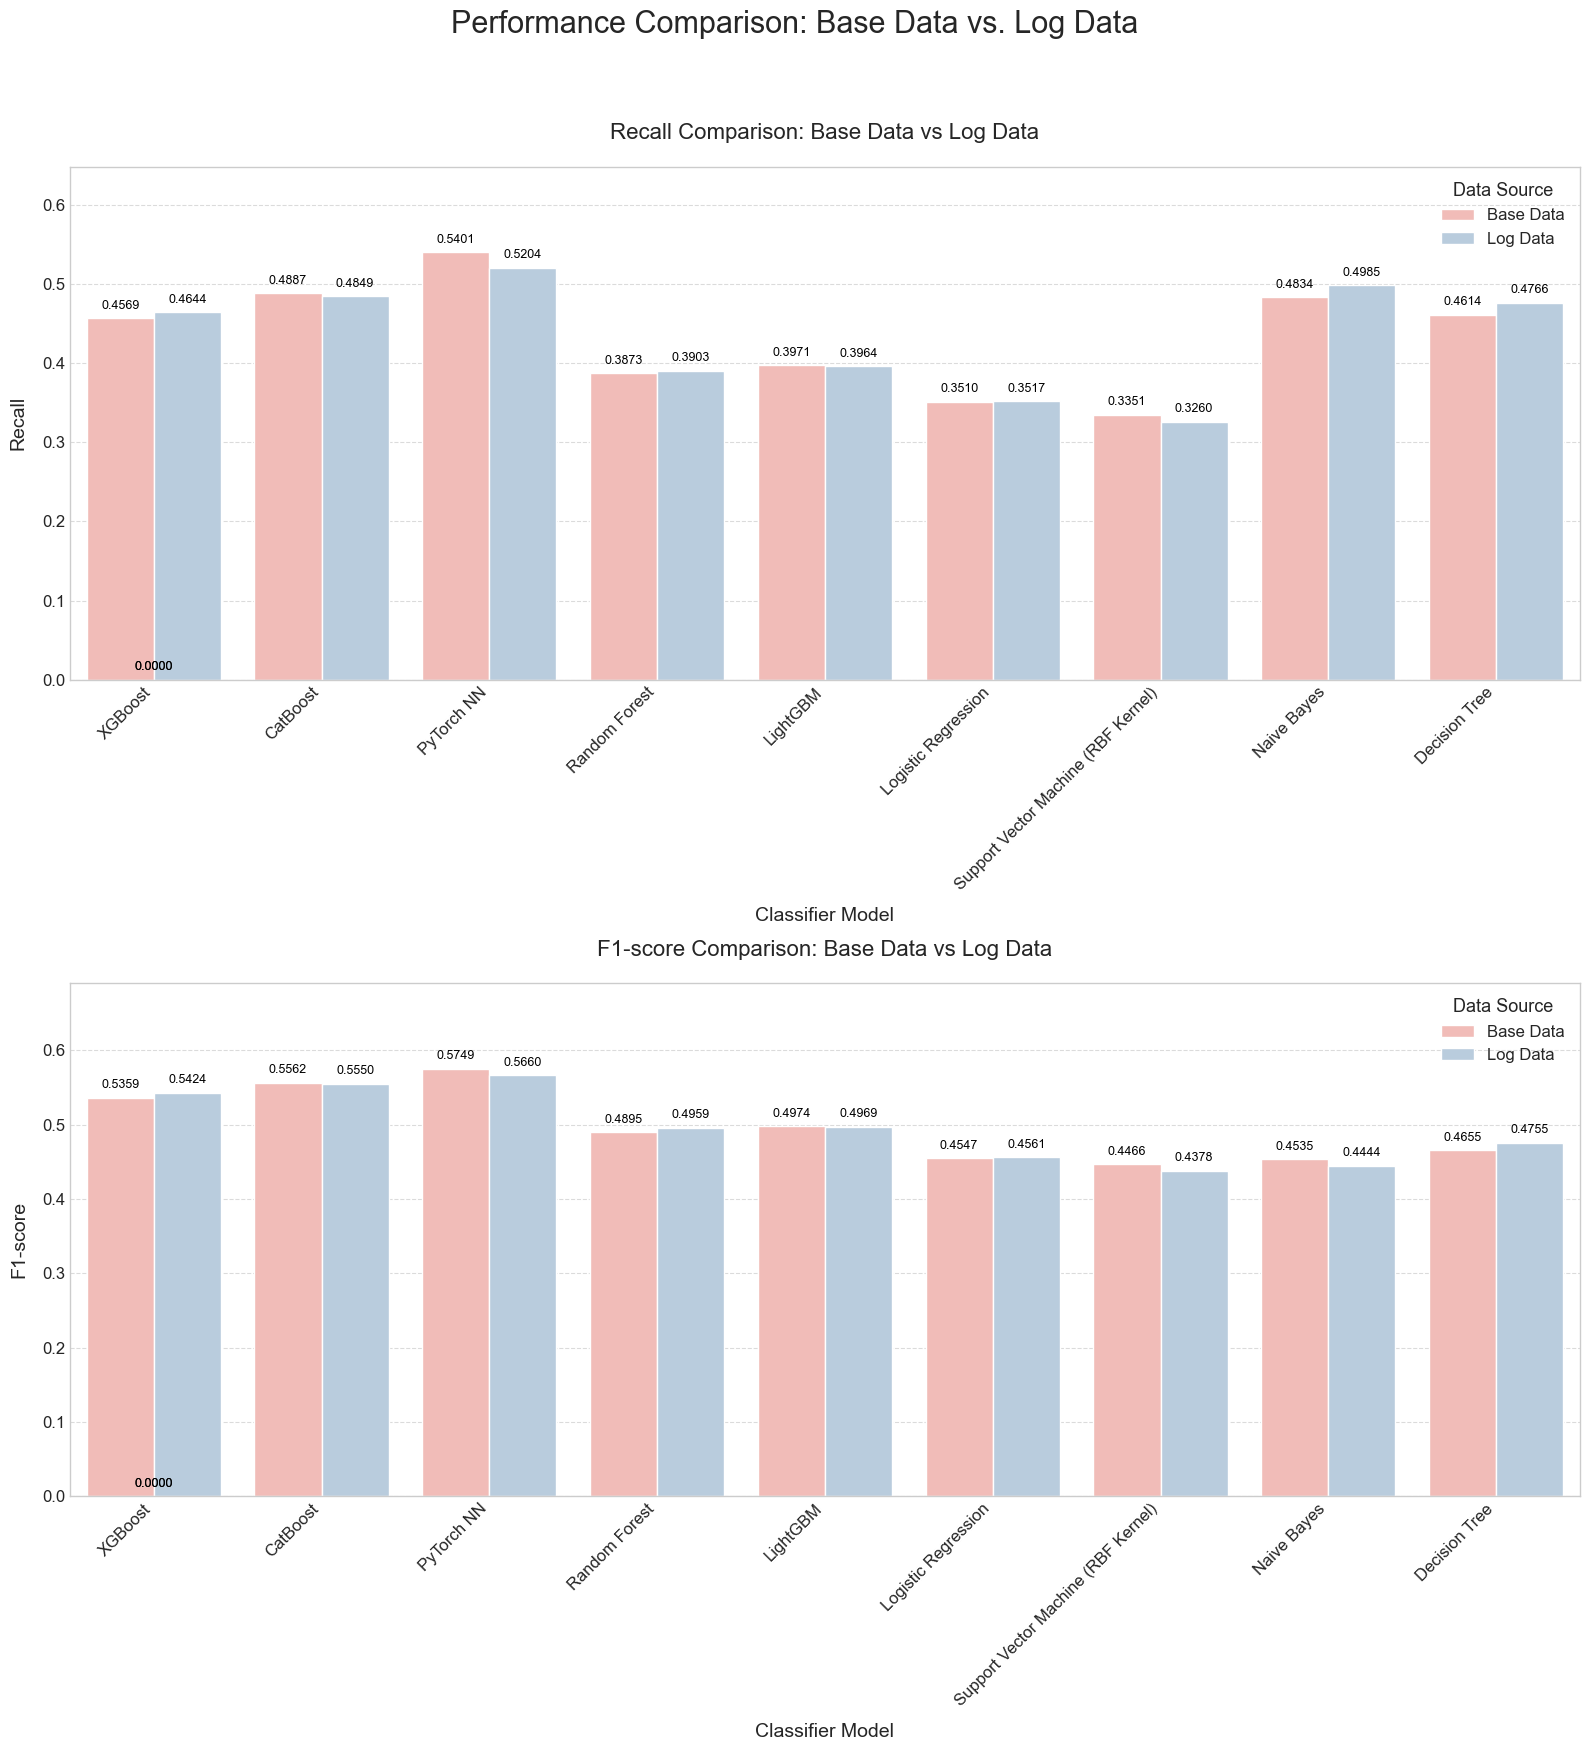

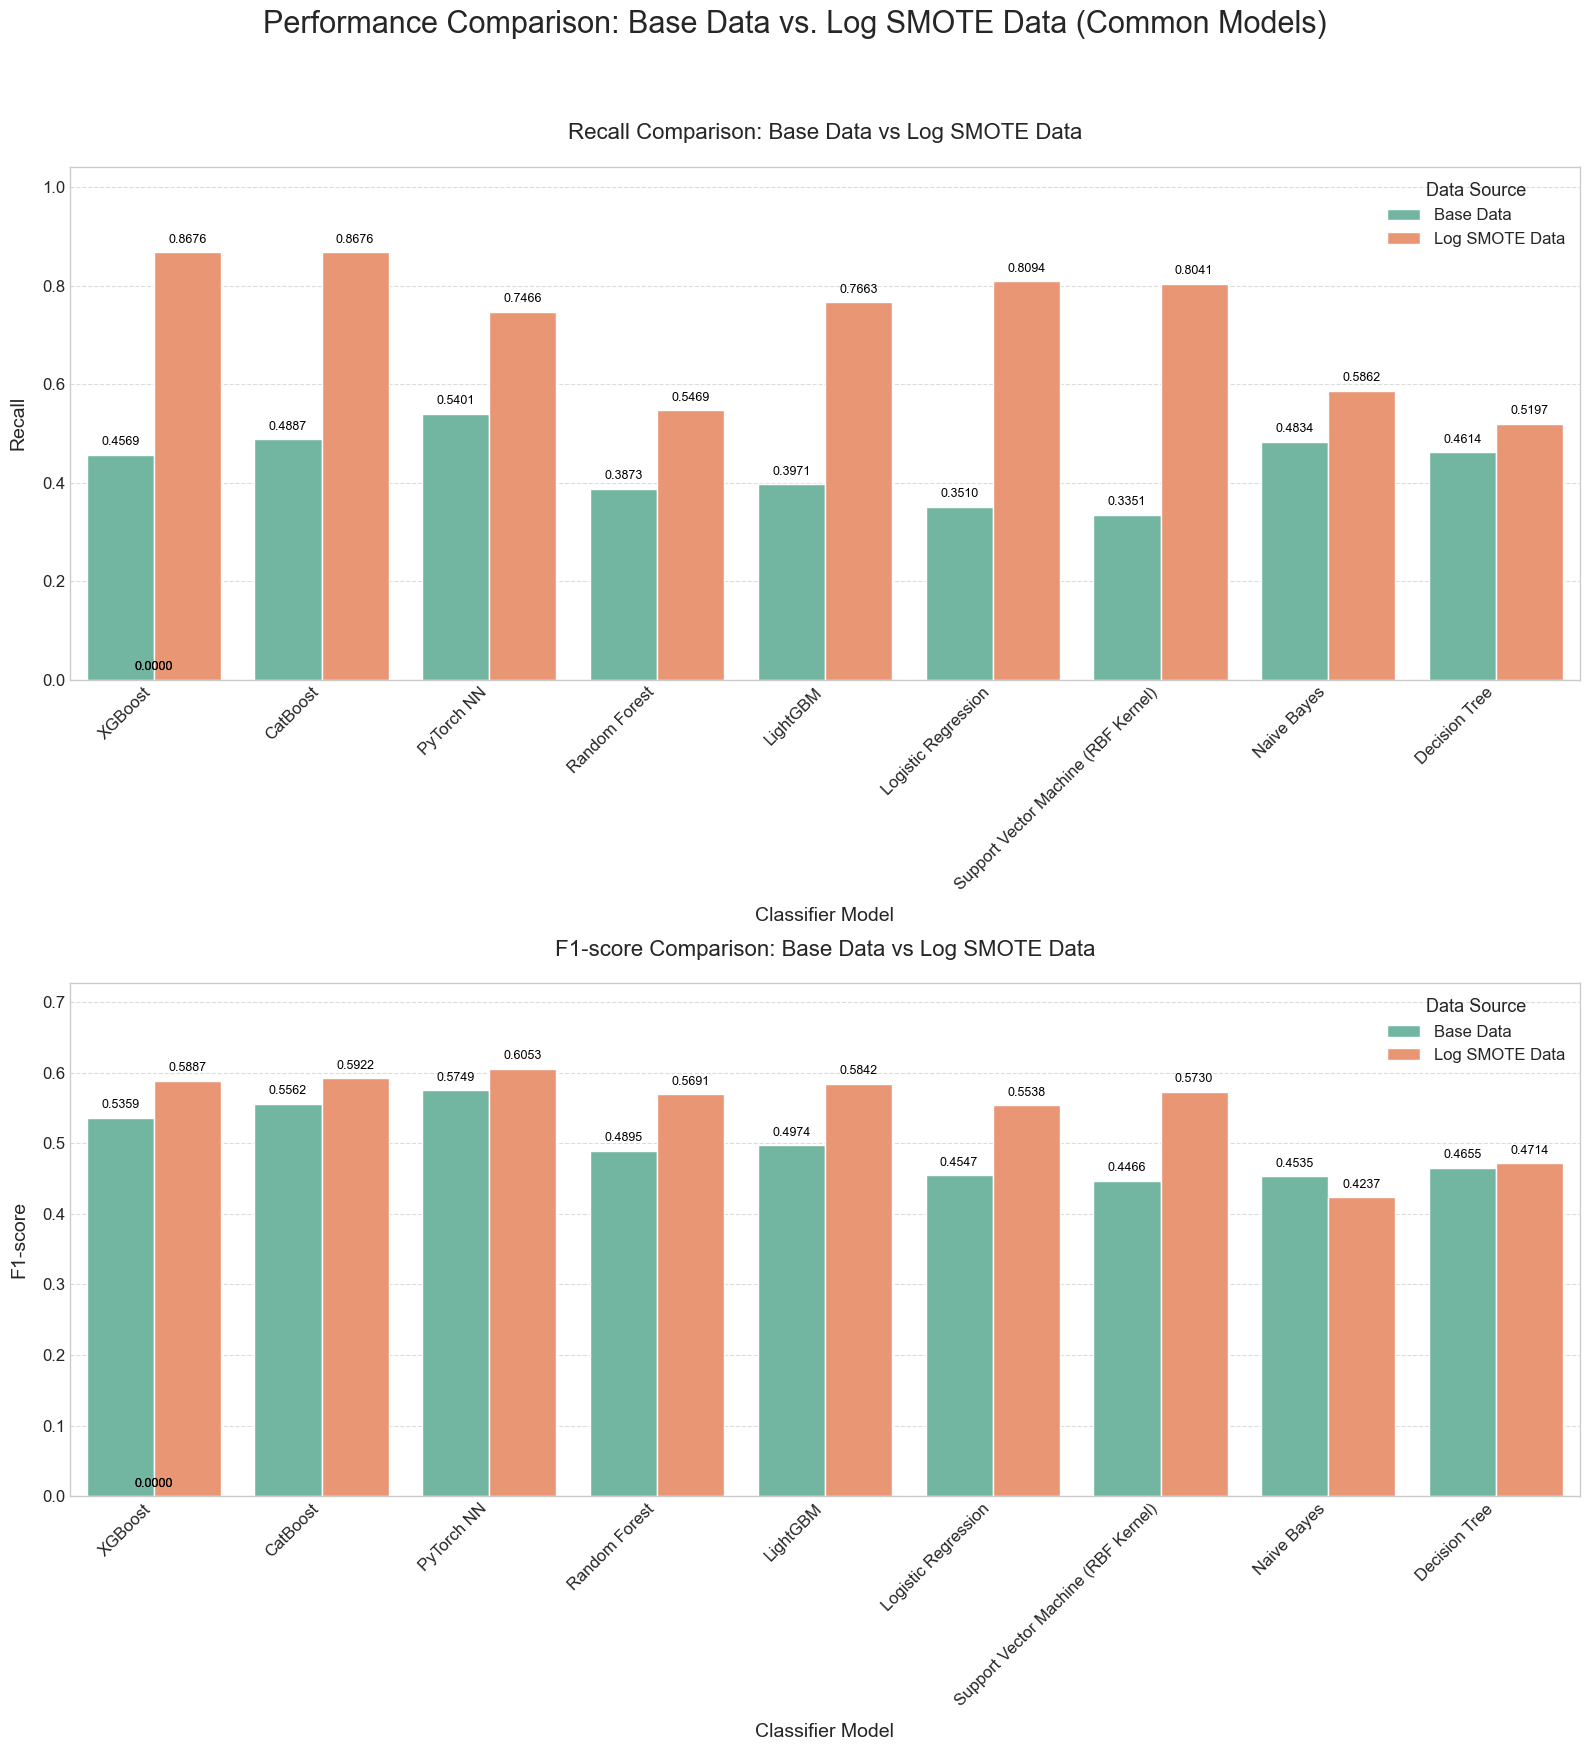

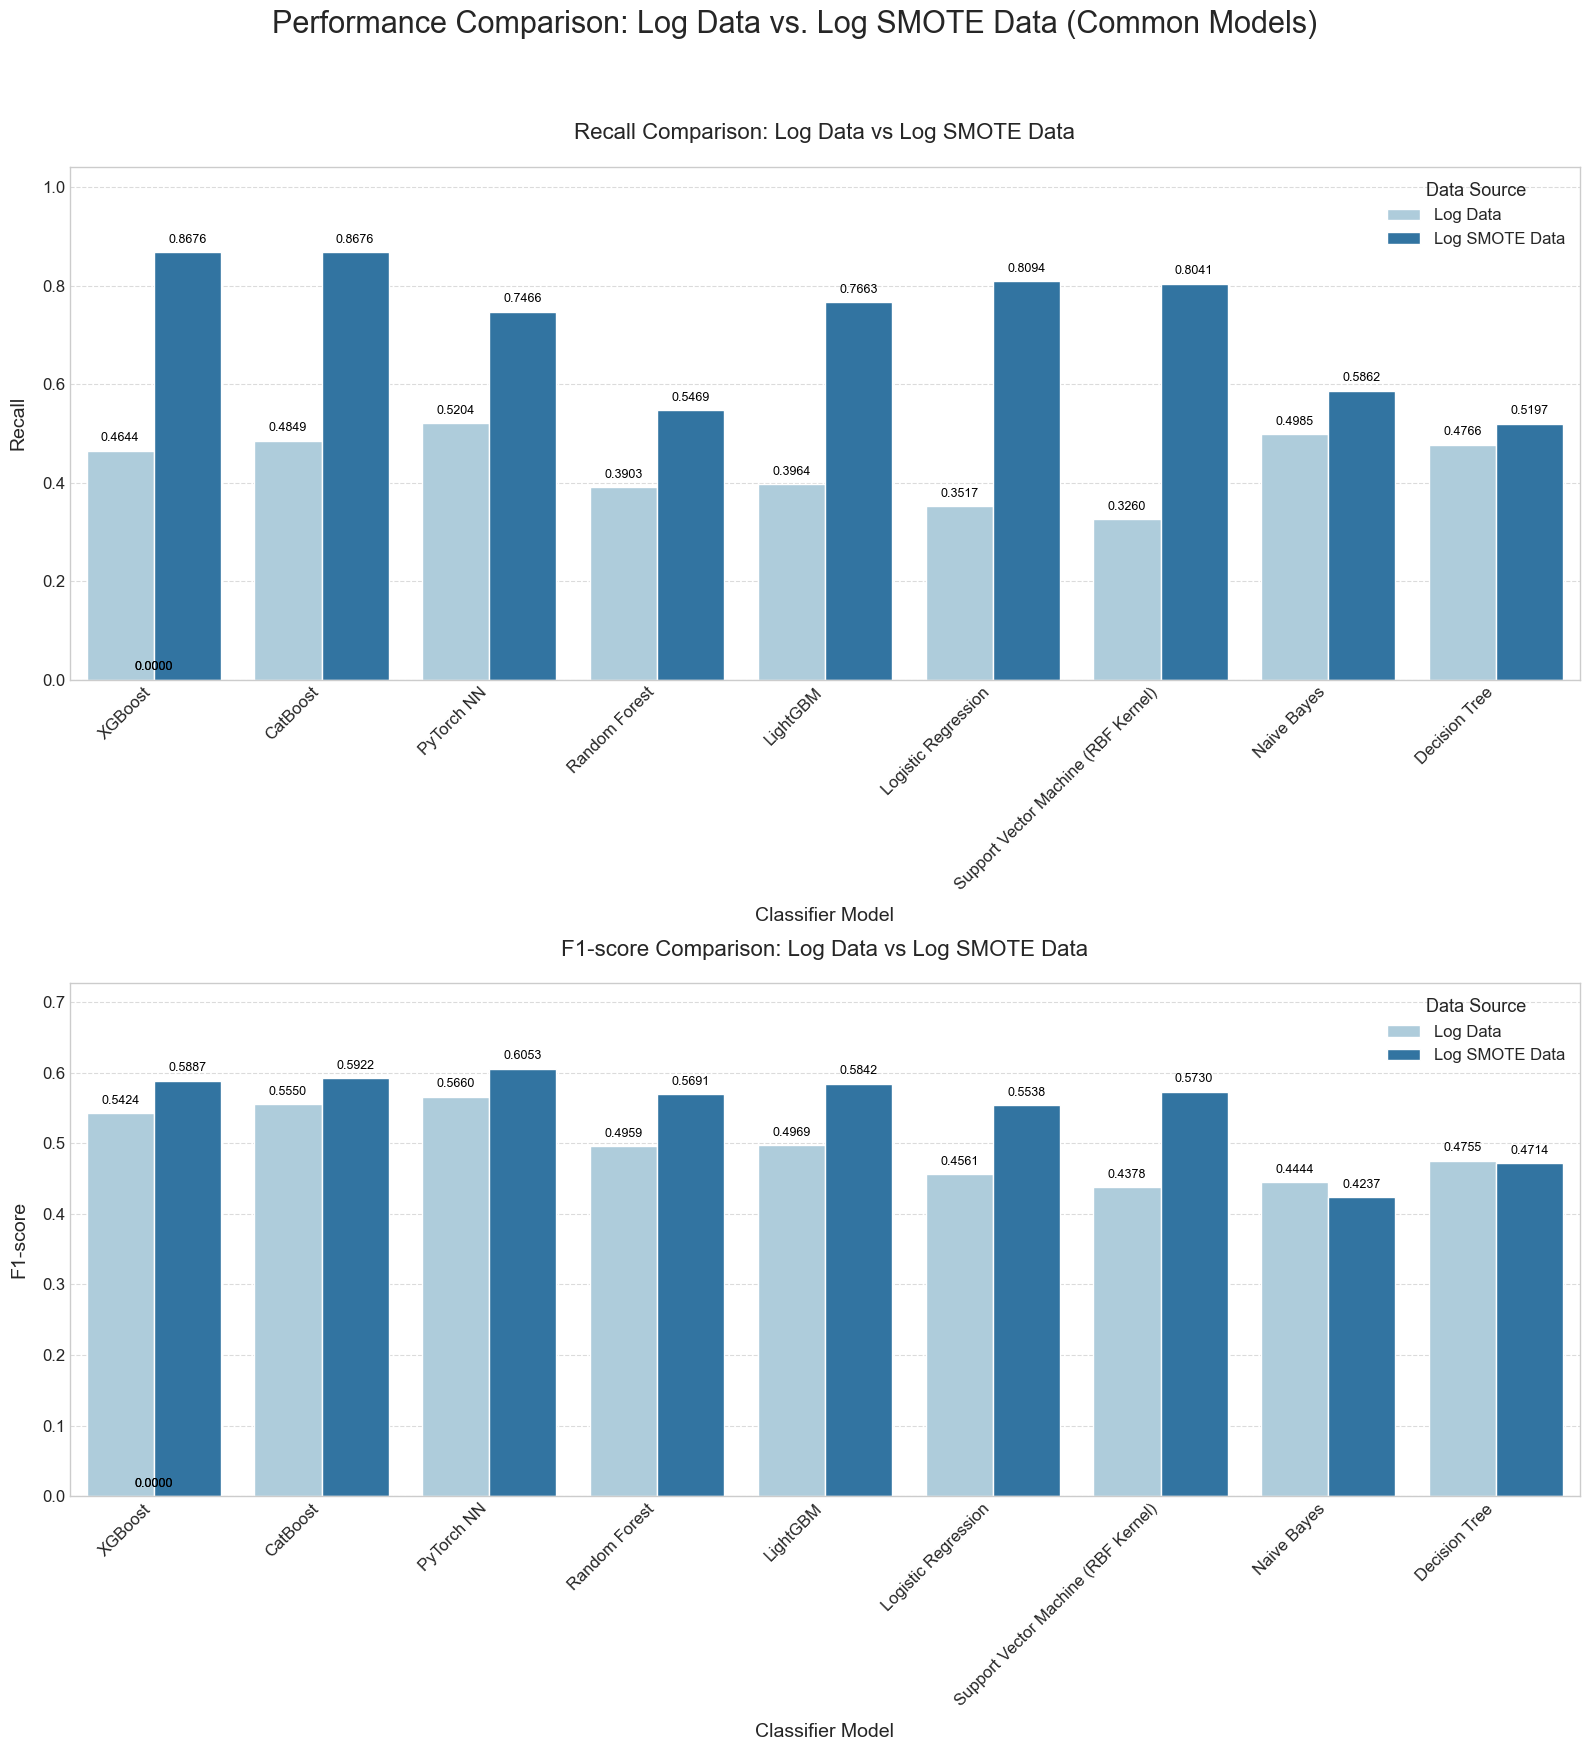

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data from images
data_base = {
    'Model': ['XGBoost', 'CatBoost', 'PyTorch NN', 'Random Forest', 'LightGBM', 'Logistic Regression', 'Support Vector Machine (RBF Kernel)', 'Naive Bayes', 'Decision Tree'],
    'Recall': [0.456884, 0.488654, 0.540091, 0.387292, 0.397126, 0.350983, 0.335098, 0.483359, 0.461422],
    'F1-score': [0.535936, 0.556177, 0.574879, 0.489484, 0.497395, 0.454679, 0.446573, 0.453513, 0.465471]
}
df_base = pd.DataFrame(data_base)

data_log = {
    'Model': ['XGBoost', 'CatBoost', 'PyTorch NN', 'LightGBM', 'Random Forest', 'Logistic Regression', 'Support Vector Machine (RBF Kernel)', 'Naive Bayes', 'Decision Tree'],
    'Recall': [0.464448, 0.484871, 0.520424, 0.396369, 0.390318, 0.351740, 0.326021, 0.498487, 0.476551],
    'F1-score': [0.542403, 0.554978, 0.566022, 0.496918, 0.495915, 0.456106, 0.437786, 0.444370, 0.475472]
}
df_log = pd.DataFrame(data_log)

data_log_smote = {
    'Model': ['Voting Classifier', 'CatBoost', 'XGBoost', 'Random Forest', 'PyTorch NN', 'LightGBM', 'Support Vector Machine (RBF Kernel)', 'Logistic Regression', 'Naive Bayes', 'Decision Tree'],
    'Recall': [0.832073, 0.867625, 0.867625, 0.546899, 0.746596, 0.766263, 0.804085, 0.809380, 0.586233, 0.519667],
    'F1-score': [0.611621, 0.592153, 0.588658, 0.569067, 0.605336, 0.584198, 0.573046, 0.553830, 0.423729, 0.471355]
}
df_log_smote = pd.DataFrame(data_log_smote)

# Standard model order for fair comparison (based on the order in base_data)
common_models = ['XGBoost', 'CatBoost', 'PyTorch NN', 'Random Forest', 'LightGBM', 'Logistic Regression', 'Support Vector Machine (RBF Kernel)', 'Naive Bayes', 'Decision Tree']

# Align dataframes by model and reindex to common_models to ensure consistent order for plotting
df_base = df_base.set_index('Model').reindex(common_models).reset_index()
df_log = df_log.set_index('Model').reindex(common_models).reset_index()

# For comparisons involving log_smote, filter out 'Voting Classifier' first, then reindex
df_log_smote_common = df_log_smote[df_log_smote['Model'] != 'Voting Classifier'].set_index('Model').reindex(common_models).reset_index()

def plot_comparison(df1, df2, df1_name, df2_name, metric, ax, palette):
    """Helper function to create a grouped bar plot for a given metric."""
    
    # Prepare data for grouped bar plot
    data_df1 = df1[['Model', metric]].copy()
    data_df1.rename(columns={metric: df1_name}, inplace=True) # Rename metric column to include df name
    
    data_df2 = df2[['Model', metric]].copy()
    data_df2.rename(columns={metric: df2_name}, inplace=True) # Rename metric column to include df name
    
    # Merge the dataframes on Model
    plot_data = pd.merge(data_df1, data_df2, on='Model')
    # Melt the DataFrame to have 'Model', 'Data Type', and the metric value for plotting with hue
    plot_data_melted = plot_data.melt(id_vars='Model', var_name='Data Source', value_name=metric)
    
    sns.barplot(x='Model', y=metric, hue='Data Source', data=plot_data_melted, ax=ax, palette=palette)
    ax.set_title(f'{metric} Comparison: {df1_name} vs {df2_name}', fontsize=16, pad=20)
    ax.set_xlabel('Classifier Model', fontsize=14, labelpad=10)
    ax.set_ylabel(metric, fontsize=14, labelpad=10)
    ax.tick_params(axis='x', labelsize=12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Data Source', fontsize=12, title_fontsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=9,
                    color='black')
    
    # Adjust y-limit to make space for labels, ensuring 0 is the minimum if all values are positive
    current_max_y = plot_data_melted[metric].max()
    ax.set_ylim(0, current_max_y * 1.20)


# Set a professional style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # A commonly available font

# --- Plot 1: base_data vs log_data ---
fig1, axes1 = plt.subplots(2, 1, figsize=(16, 18)) # Adjusted figsize
palette1 = sns.color_palette("Pastel1", 2)

plot_comparison(df_base, df_log, 'Base Data', 'Log Data', 'Recall', axes1[0], palette1)
plot_comparison(df_base, df_log, 'Base Data', 'Log Data', 'F1-score', axes1[1], palette1)

fig1.suptitle('Performance Comparison: Base Data vs. Log Data', fontsize=22, y=1.00) # Adjusted y for suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap and make space for x-labels
plt.show()

# --- Plot 2: base_data vs log_smote_data (common models) ---
fig2, axes2 = plt.subplots(2, 1, figsize=(16, 18))
palette2 = sns.color_palette("Set2", 2)

plot_comparison(df_base, df_log_smote_common, 'Base Data', 'Log SMOTE Data', 'Recall', axes2[0], palette2)
plot_comparison(df_base, df_log_smote_common, 'Base Data', 'Log SMOTE Data', 'F1-score', axes2[1], palette2)

fig2.suptitle('Performance Comparison: Base Data vs. Log SMOTE Data (Common Models)', fontsize=22, y=1.00)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# --- Plot 3: log_data vs log_smote_data (common models) ---
fig3, axes3 = plt.subplots(2, 1, figsize=(16, 18))
palette3 = sns.color_palette("Paired", 2)

plot_comparison(df_log, df_log_smote_common, 'Log Data', 'Log SMOTE Data', 'Recall', axes3[0], palette3)
plot_comparison(df_log, df_log_smote_common, 'Log Data', 'Log SMOTE Data', 'F1-score', axes3[1], palette3)

fig3.suptitle('Performance Comparison: Log Data vs. Log SMOTE Data (Common Models)', fontsize=22, y=1.00)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()





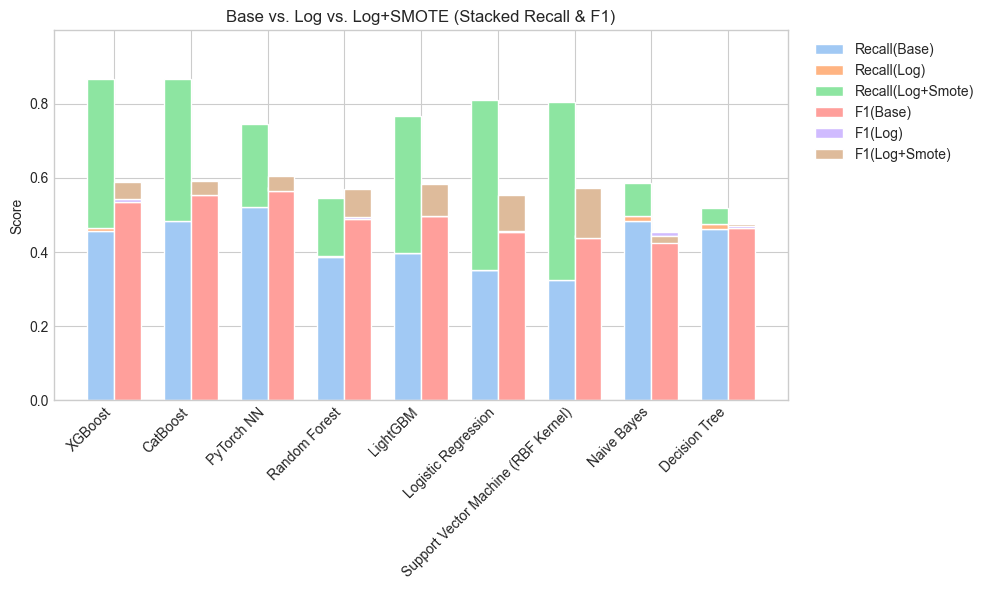

In [104]:
# ...existing code...

import numpy as np
import matplotlib.pyplot as plt

# 合并基准、log、log_smote的数据
df_merged = pd.DataFrame({
    'Model': common_models,
    'Recall_Base': df_base['Recall'],
    'Recall_Log': df_log['Recall'],
    'Recall_Smote': df_log_smote_common['Recall'],
    'F1_Base': df_base['F1-score'],
    'F1_Log': df_log['F1-score'],
    'F1_Smote': df_log_smote_common['F1-score']
})

# 分别计算log与smote相对前者的差值，用于累计柱状图
df_merged['Recall_diff_log'] = df_merged['Recall_Log'] - df_merged['Recall_Base']
df_merged['Recall_diff_smote'] = df_merged['Recall_Smote'] - df_merged['Recall_Log']
df_merged['F1_diff_log'] = df_merged['F1_Log'] - df_merged['F1_Base']
df_merged['F1_diff_smote'] = df_merged['F1_Smote'] - df_merged['F1_Log']

x = np.arange(len(df_merged))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制Recall的累计柱状 (左侧)
ax.bar(x - bar_width/2,
       df_merged['Recall_Base'],
       width=bar_width,
       label='Recall(Base)')

ax.bar(x - bar_width/2,
       df_merged['Recall_diff_log'],
       width=bar_width,
       bottom=df_merged['Recall_Base'],
       label='Recall(Log)')

ax.bar(x - bar_width/2,
       df_merged['Recall_diff_smote'],
       width=bar_width,
       bottom=df_merged['Recall_Base'] + df_merged['Recall_diff_log'],
       label='Recall(Log+Smote)')

# 绘制F1的累计柱状 (右侧)
ax.bar(x + bar_width/2,
       df_merged['F1_Base'],
       width=bar_width,
       label='F1(Base)')

ax.bar(x + bar_width/2,
       df_merged['F1_diff_log'],
       width=bar_width,
       bottom=df_merged['F1_Base'],
       label='F1(Log)')

ax.bar(x + bar_width/2,
       df_merged['F1_diff_smote'],
       width=bar_width,
       bottom=df_merged['F1_Base'] + df_merged['F1_diff_log'],
       label='F1(Log+Smote)')

# X轴标签与美化
ax.set_xticks(x)
ax.set_xticklabels(df_merged['Model'], rotation=45, ha='right')
ax.set_ylim(0, max(df_merged['Recall_Smote'].max(), df_merged['F1_Smote'].max()) * 1.15)
ax.set_ylabel('Score')
ax.set_title('Base vs. Log vs. Log+SMOTE (Stacked Recall & F1)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 结果分析
- Recall（召回率）升高
- Precision（精确率）降低
- F1-score 升高的原因

### precision分析
在使用SMOTE后牺牲了precision精度，所以我们可以再次尝试添加业务约束

设置"精确率≥50%的前提下，最大化召回率"的约束非常合理：

避免资源浪费：银行要求最低50%的精确率意味着每打两通电话至少有一通会成功，这能有效控制人力和时间成本
明确业务目标：在确保基本转化效率的前提下，尽可能触达更多潜在客户
量化决策标准：为模型选择和阈值调整提供了明确指标

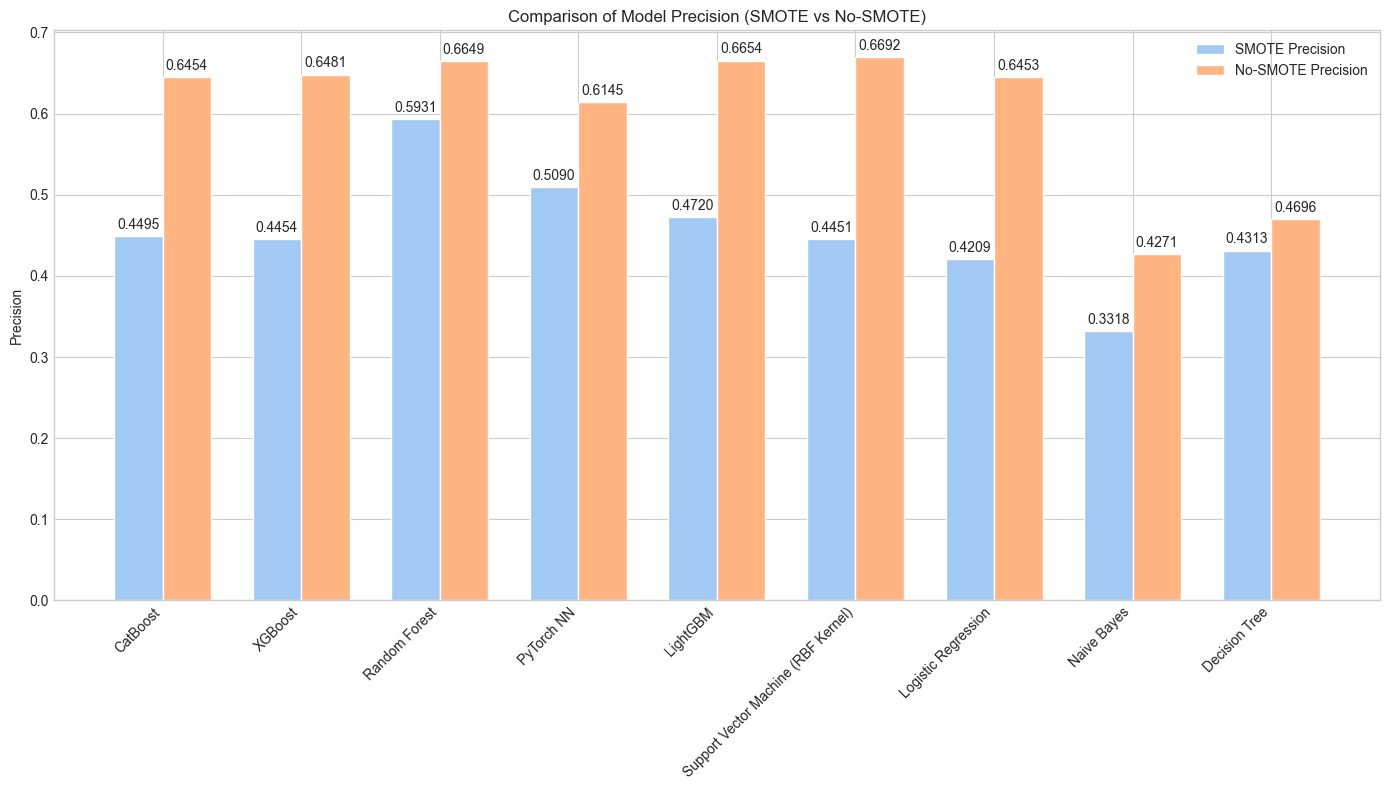

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# 从图片中提取的数据
models = ['CatBoost', 'XGBoost', 'Random Forest', 'PyTorch NN', 'LightGBM',
            'Support Vector Machine (RBF Kernel)', 'Logistic Regression', 'Naive Bayes', 'Decision Tree']
precision_img1 = [0.449451, 0.445437, 0.593109, 0.509025, 0.472041, 0.445142, 0.420928, 0.331764, 0.431262]
precision_img2 = [0.645355, 0.648069, 0.664935, 0.614458, 0.665399, 0.669184, 0.645341, 0.427139, 0.469592]

# 设置条形图的位置
x = np.arange(len(models))  # 模型标签的位置
width = 0.35  # 条形的宽度

fig, ax = plt.subplots(figsize=(14, 8)) # 调整图表尺寸以便更好地显示标签

# 绘制条形图
rects1 = ax.bar(x - width/2, precision_img1, width, label='SMOTE Precision')
rects2 = ax.bar(x + width/2, precision_img2, width, label='No-SMOTE Precision')

# 添加文本标签、标题和自定义x轴刻度标签等。
ax.set_ylabel('Precision')
ax.set_title('Comparison of Model Precision (SMOTE vs No-SMOTE)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right") # 旋转x轴标签以防重叠
ax.legend()

# 在条形上方显示数值
def autolabel(rects):
    """在每个条形上方附加一个文本标签，显示其高度。"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height), # 格式化为4位小数
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout() # 调整布局以适应标签
plt.show()

In [106]:

def find_optimal_threshold(y_true, y_prob, min_precision=0.5, steps=100):
    """
    寻找满足最小精确率要求的同时最大化召回率的最优阈值
    
    参数:
        y_true: 真实标签
        y_prob: 预测概率
        min_precision: 最小精确率要求
        steps: 搜索步骤数
    
    返回:
        optimal_threshold: 最优阈值
        max_recall: 在该阈值下的召回率
        precision_at_threshold: 在该阈值下的精确率
    """
    thresholds = np.linspace(0, 1, steps)
    max_recall = 0
    optimal_threshold = 1.0  # 初始化为最保守的阈值
    precision_at_threshold = 0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # 处理极端情况：没有正例预测
        if np.sum(y_pred) == 0:
            continue
            
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # 如果精确率达到最小要求且召回率更高
        if precision >= min_precision and recall > max_recall:
            max_recall = recall
            optimal_threshold = threshold
            precision_at_threshold = precision
    
    return optimal_threshold, max_recall, precision_at_threshold

# 存储约束优化后的结果
constrained_results = {}


--- 应用业务约束: 精确率≥50%的前提下最大化召回率 ---


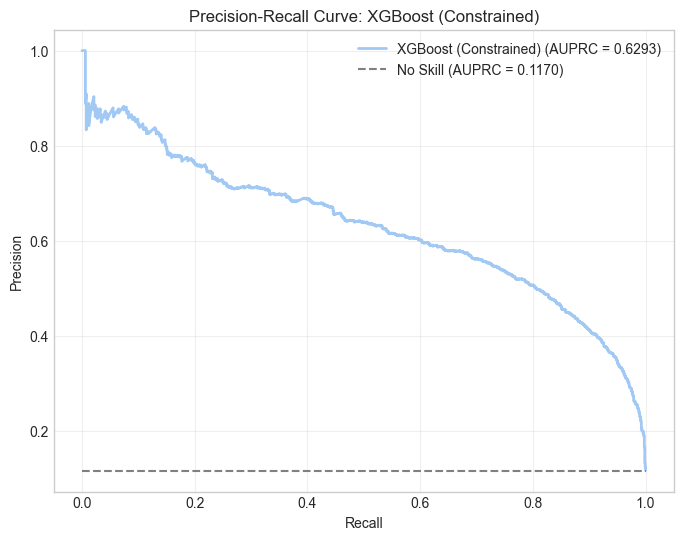

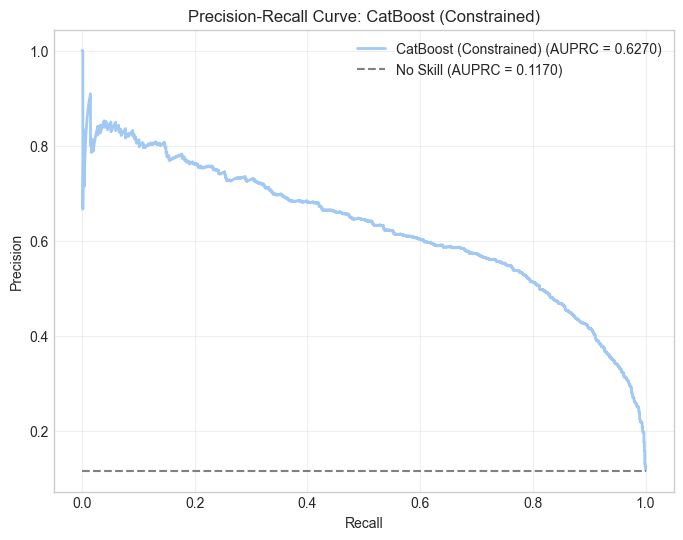

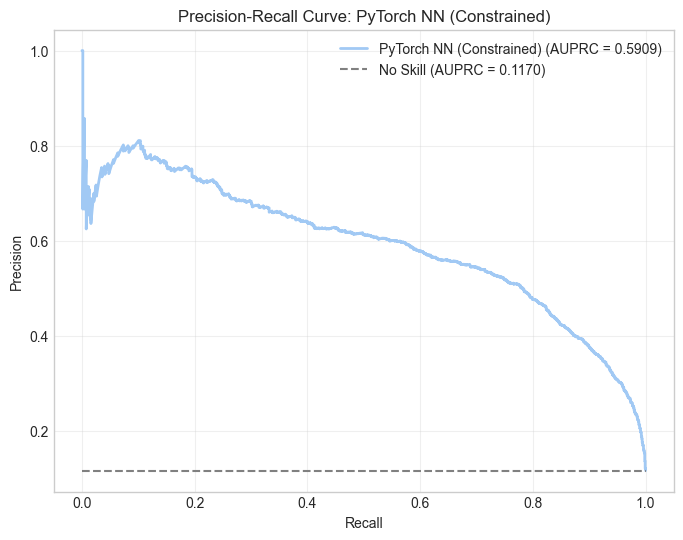

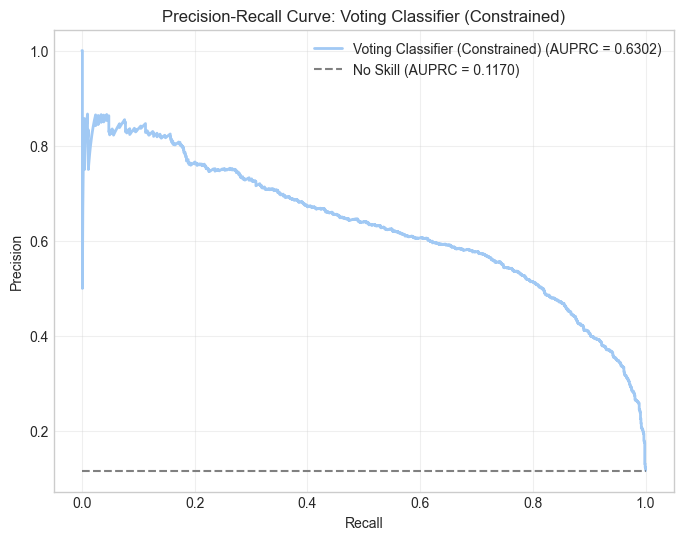


--- 业务约束下的模型性能 (精确率≥50%) ---
                   Threshold  Precision    Recall  F1-score    G-mean  \
Voting Classifier   0.575758   0.500697  0.815431  0.620432  0.852998   
CatBoost            0.626263   0.503756  0.811649  0.621669  0.851877   
XGBoost             0.626263   0.501415  0.804085  0.617664  0.847898   
PyTorch NN          0.535354   0.501214  0.780635  0.610470  0.836846   

                      AUPRC  
Voting Classifier  0.630178  
CatBoost           0.627050  
XGBoost            0.629339  
PyTorch NN         0.590914  


In [107]:
# 应用约束优化到所有模型
# 添加一个新的单元格执行以下代码

print("\n--- 应用业务约束: 精确率≥50%的前提下最大化召回率 ---")

# 对于已训练的模型，获取它们的概率预测并找到最优阈值
# XGBoost模型
X_test_processed = fitted_preprocessor.transform(X_test)
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()
xgb_probs = xgboost_model.predict_proba(X_test_processed)[:, 1]
xgb_threshold, xgb_recall, xgb_precision = find_optimal_threshold(y_test, xgb_probs)

# CatBoost模型
catboost_probs = catboost_model.predict_proba(X_test)[:, 1]
cat_threshold, cat_recall, cat_precision = find_optimal_threshold(y_test, catboost_probs)

# PyTorch模型
torch_threshold, torch_recall, torch_precision = find_optimal_threshold(y_test, all_probabilities_nn)

# 投票分类器
vote_threshold, vote_recall, vote_precision = find_optimal_threshold(y_test, ensemble_proba)

# 用最优阈值生成新的预测
xgb_pred_constrained = (xgb_probs >= xgb_threshold).astype(int)
cat_pred_constrained = (catboost_probs >= cat_threshold).astype(int)
torch_pred_constrained = (all_probabilities_nn >= torch_threshold).astype(int)
vote_pred_constrained = (ensemble_proba >= vote_threshold).astype(int)

# 存储约束下的结果
constrained_results["XGBoost"] = {
    "Threshold": xgb_threshold,
    "Precision": precision_score(y_test, xgb_pred_constrained),
    "Recall": recall_score(y_test, xgb_pred_constrained),
    "F1-score": f1_score(y_test, xgb_pred_constrained)
}

constrained_results["CatBoost"] = {
    "Threshold": cat_threshold,
    "Precision": precision_score(y_test, cat_pred_constrained),
    "Recall": recall_score(y_test, cat_pred_constrained),
    "F1-score": f1_score(y_test, cat_pred_constrained)
}

constrained_results["PyTorch NN"] = {
    "Threshold": torch_threshold,
    "Precision": precision_score(y_test, torch_pred_constrained),
    "Recall": recall_score(y_test, torch_pred_constrained),
    "F1-score": f1_score(y_test, torch_pred_constrained)
}

constrained_results["Voting Classifier"] = {
    "Threshold": vote_threshold,
    "Precision": precision_score(y_test, vote_pred_constrained),
    "Recall": recall_score(y_test, vote_pred_constrained),
    "F1-score": f1_score(y_test, vote_pred_constrained)
}


# 在约束优化结果中添加G-mean
constrained_results["XGBoost"]["G-mean"] = g_mean_score(y_test, xgb_pred_constrained)
constrained_results["CatBoost"]["G-mean"] = g_mean_score(y_test, cat_pred_constrained)
constrained_results["PyTorch NN"]["G-mean"] = g_mean_score(y_test, torch_pred_constrained)
constrained_results["Voting Classifier"]["G-mean"] = g_mean_score(y_test, vote_pred_constrained)


# 在约束优化结果中添加AUPRC
constrained_results["XGBoost"]["AUPRC"] = plot_pr_curve(y_test, xgb_probs, "XGBoost (Constrained)")
constrained_results["CatBoost"]["AUPRC"] = plot_pr_curve(y_test, catboost_probs, "CatBoost (Constrained)")
constrained_results["PyTorch NN"]["AUPRC"] = plot_pr_curve(y_test, all_probabilities_nn, "PyTorch NN (Constrained)")
constrained_results["Voting Classifier"]["AUPRC"] = plot_pr_curve(y_test, ensemble_proba, "Voting Classifier (Constrained)")

# 转换为DataFrame并显示
df_constrained = pd.DataFrame(constrained_results).T
df_constrained = df_constrained.sort_values(by="Recall", ascending=False)
print("\n--- 业务约束下的模型性能 (精确率≥50%) ---")
print(df_constrained)

<Figure size 1200x800 with 0 Axes>

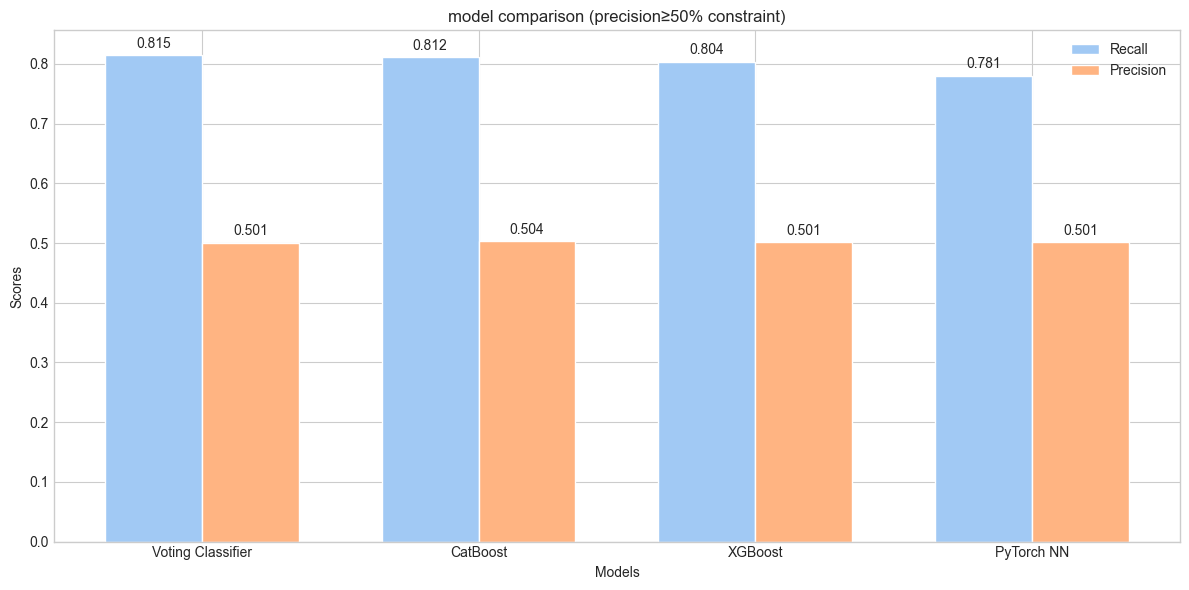

In [108]:
# 可视化约束结果
plt.figure(figsize=(12, 8))
models = df_constrained.index
recalls = df_constrained["Recall"]
precisions = df_constrained["Precision"]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, recalls, width, label='Recall')
rects2 = ax.bar(x + width/2, precisions, width, label='Precision')

# 添加文本标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('model comparison (precision≥50% constraint)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

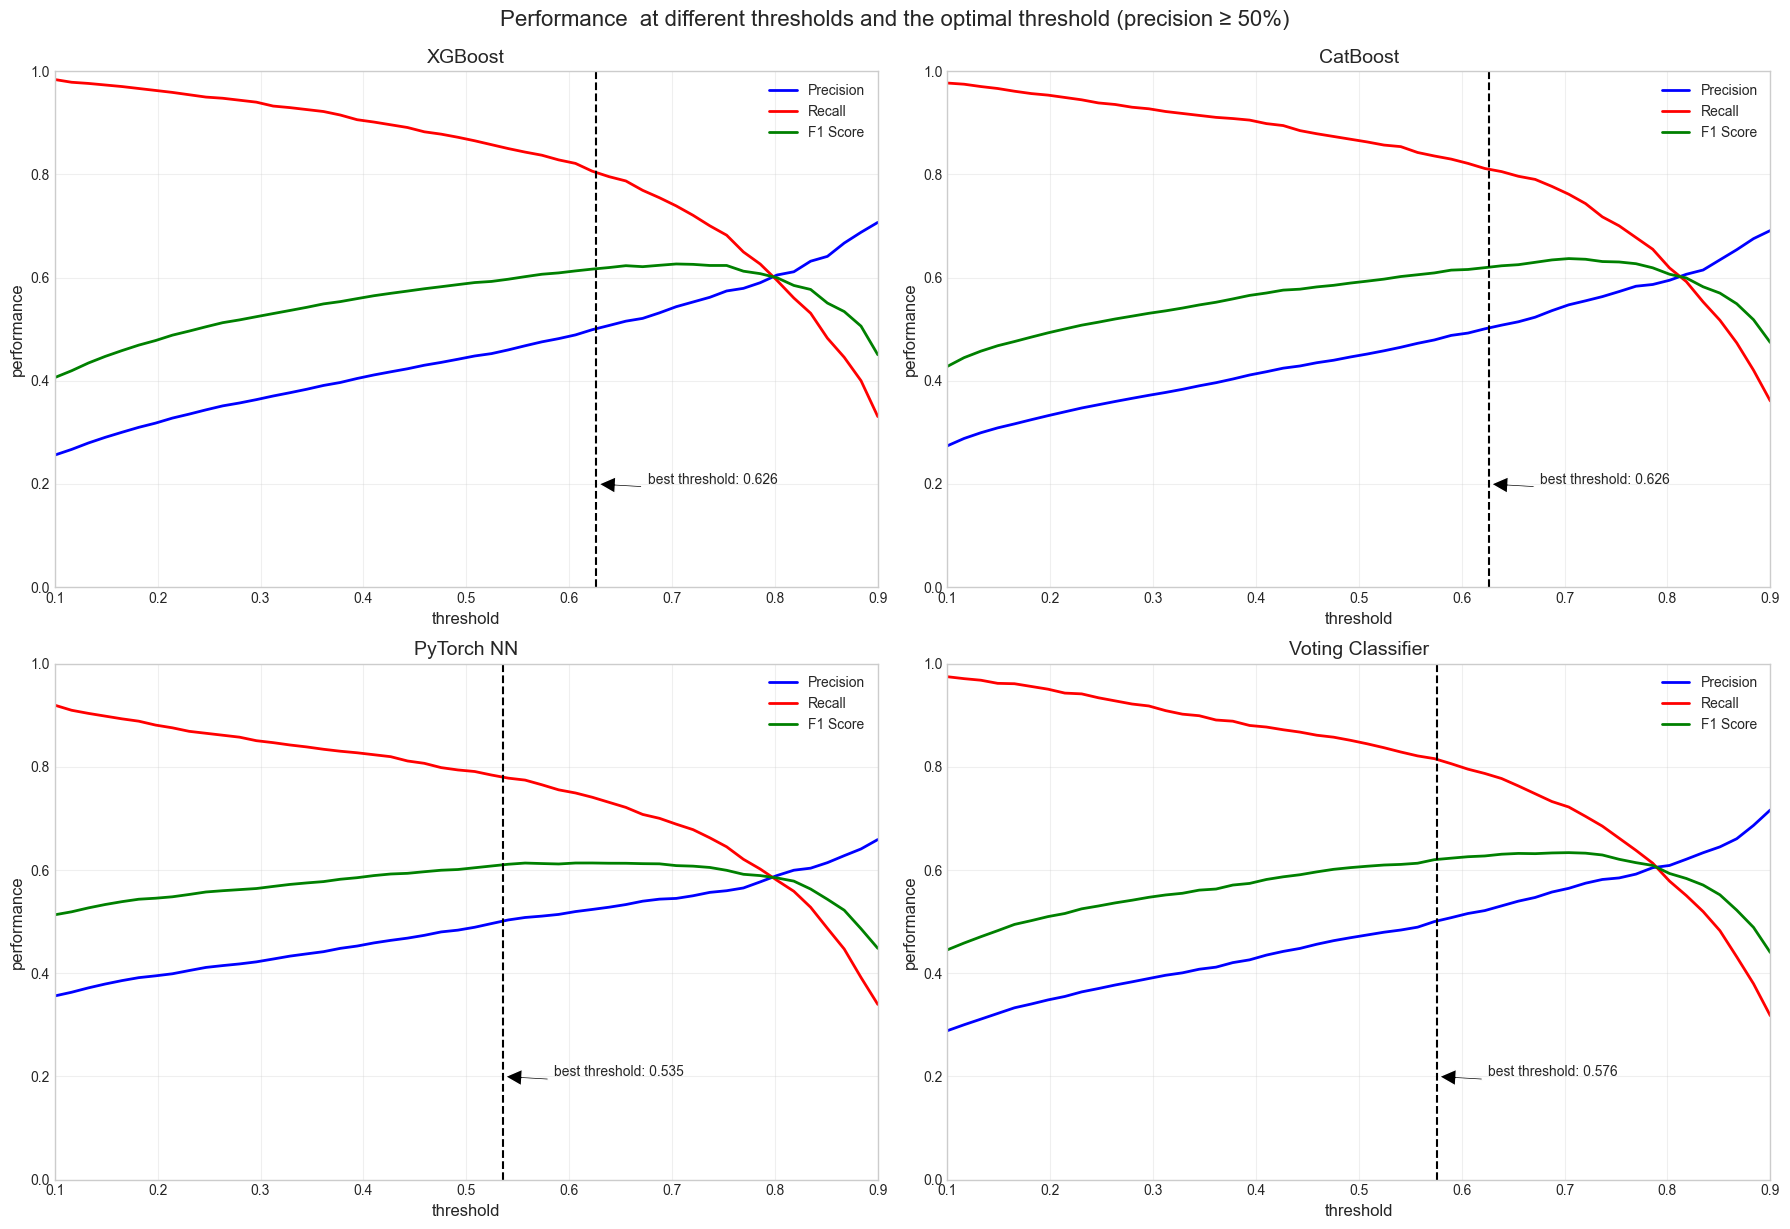

In [109]:
# 为模型的阈值和对应的性能指标创建更详细的可视化
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

models = ["XGBoost", "CatBoost", "PyTorch NN", "Voting Classifier"]
colors = ['blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'd']

for i, model_name in enumerate(models):
    row = i // 2
    col = i % 2
    
    # 获取模型的概率预测
    if model_name == "XGBoost":
        probs = xgb_probs
    elif model_name == "CatBoost":
        probs = catboost_probs
    elif model_name == "PyTorch NN":
        probs = all_probabilities_nn
    else:  # Voting Classifier
        probs = ensemble_proba
    
    # 计算不同阈值下的精确率和召回率
    thresholds = np.linspace(0.1, 0.9, 50)
    precision_values = []
    recall_values = []
    f1_values = []
    
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        if np.sum(y_pred) > 0:  # 避免除零错误
            precision_values.append(precision_score(y_test, y_pred))
            recall_values.append(recall_score(y_test, y_pred))
            f1_values.append(f1_score(y_test, y_pred))
        else:
            precision_values.append(0)
            recall_values.append(0)
            f1_values.append(0)
    
    # 绘制曲线
    axes[row, col].plot(thresholds, precision_values, 'b-', label='Precision', linewidth=2)
    axes[row, col].plot(thresholds, recall_values, 'r-', label='Recall', linewidth=2)
    axes[row, col].plot(thresholds, f1_values, 'g-', label='F1 Score', linewidth=2)
    
    # 标记最优阈值
    optimal_threshold = constrained_results[model_name]["Threshold"]
    axes[row, col].axvline(x=optimal_threshold, color='k', linestyle='--', linewidth=1.5)
    axes[row, col].annotate(f'best threshold: {optimal_threshold:.3f}', 
                           xy=(optimal_threshold, 0.2),
                           xytext=(optimal_threshold + 0.05, 0.2),
                           arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # 设置图形属性
    axes[row, col].set_title(f'{model_name}', fontsize=14)
    axes[row, col].set_xlabel('threshold', fontsize=12)
    axes[row, col].set_ylabel('performance', fontsize=12)
    axes[row, col].set_xlim(0.1, 0.9)
    axes[row, col].set_ylim(0, 1)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend()

plt.tight_layout()
plt.suptitle('Performance  at different thresholds and the optimal threshold (precision ≥ 50%)', fontsize=16, y=1.02)
plt.show()


--- 约束前后模型性能对比 ---
                                   Precision    Recall  F1-score    Gmeans  \
XGBoost (Unconstrained)             0.445437  0.867625  0.588658  0.862260   
CatBoost (Unconstrained)            0.449451  0.867625  0.592153  0.863418   
Voting Classifier (Unconstrained)   0.471380  0.847201  0.605733  0.860575   
Voting Classifier (precision≥50%)   0.500697  0.815431  0.620432  0.852998   
CatBoost (precision≥50%)            0.503756  0.811649  0.621669  0.851877   
XGBoost (precision≥50%)             0.501415  0.804085  0.617664  0.847898   
PyTorch NN (Unconstrained)          0.486989  0.792738  0.603339  0.839675   
PyTorch NN (precision≥50%)          0.501214  0.780635  0.610470  0.836846   

                                      AUPRC  
XGBoost (Unconstrained)            0.629339  
CatBoost (Unconstrained)           0.627050  
Voting Classifier (Unconstrained)  0.630178  
Voting Classifier (precision≥50%)  0.630178  
CatBoost (precision≥50%)           0.627050  
X

<Figure size 1400x800 with 0 Axes>

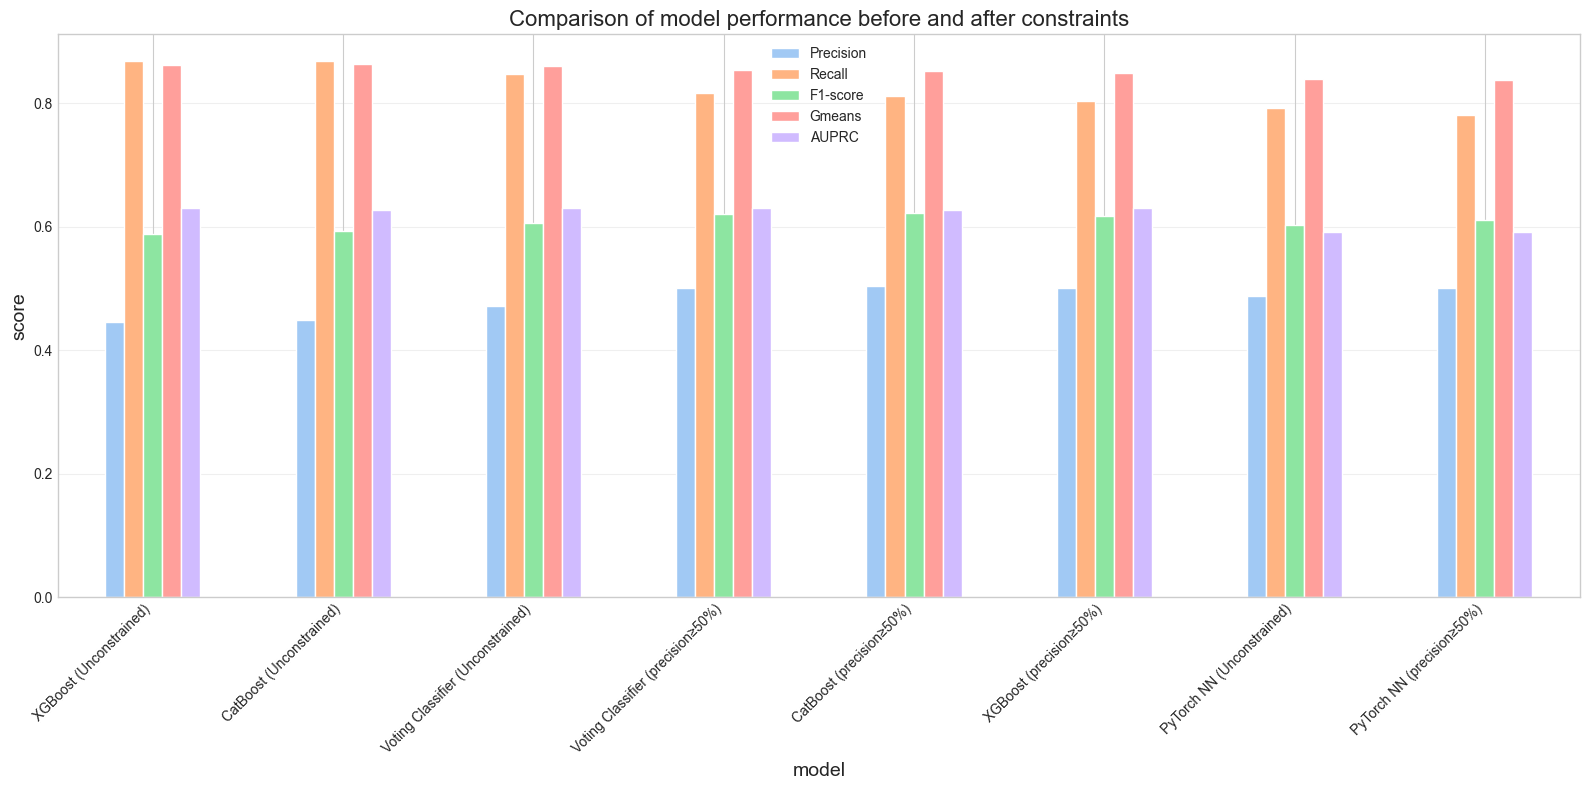

In [110]:
# 比较约束前后的结果
comparative_results = {}

# 添加约束前的结果
for model_name in ["XGBoost", "CatBoost", "PyTorch NN", "Voting Classifier"]:
    if model_name in results:
        comparative_results[f"{model_name} (Unconstrained)"] = {
            "Precision": results[model_name]["Precision"],
            "Recall": results[model_name]["Recall"],
            "F1-score": results[model_name]["F1-score"],
            'Gmeans': results[model_name]["G-mean"],
            "AUPRC": results[model_name]["AUPRC"]
        }

# 添加约束后的结果
for model_name in ["XGBoost", "CatBoost", "PyTorch NN", "Voting Classifier"]:
    if model_name in constrained_results:
        comparative_results[f"{model_name} (precision≥50%)"] = {
            "Precision": constrained_results[model_name]["Precision"],
            "Recall": constrained_results[model_name]["Recall"],
            "F1-score": constrained_results[model_name]["F1-score"],
            'Gmeans': constrained_results[model_name]["G-mean"],
            "AUPRC": constrained_results[model_name]["AUPRC"]
        }

# 转换为DataFrame并可视化
df_comparative = pd.DataFrame(comparative_results).T
df_comparative = df_comparative.sort_values(by=["Recall"], ascending=False)

print("\n--- 约束前后模型性能对比 ---")
print(df_comparative)

# 可视化对比
plt.figure(figsize=(14, 8))
df_comparative.plot(kind='bar', figsize=(16, 8))
plt.title('Comparison of model performance before and after constraints', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('score', fontsize=14)
plt.xticks(rotation=45, ha='right')
#调整label格式

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 整体思路理解

- 1.首先EDA探索数据分布：
  - 发现空缺值，但是空缺值都是类别变量，所以不直接删除而是替换为unknown不丢失信息。
  - 查看数值类型数据分布，发现右偏严重，可能影响模型预测。于是考虑log1p转换
  - 发现数据类别不均衡，负样本是正样本7倍左右
- 2.baseline model：
  - 尝试使用多种不同的模型预测演示未处理数据下的大概样式，得到的recall和f1不是很高
- 3.log_baseline model:
  - 尝试对数据log，看看是否是因为数据偏移导致。发现效果提升不是很大。这时候注意力转到类别不均衡上
- 4.log_smote_baseline model：
  - 对于大部分模型使用smote过采样的数据，解决类别不均衡
  - 对于catboost，因为其本身善于处理类别变量，且可通过scale_pos_weight=imbalance_ratio自动调节权重所以使用原数据，效果最佳。
  - 最终发现recall和f1-score都有较明显提升。结论是：数据的均衡对于业务的重要性之大
  - 这里又探索性的借鉴集成学习思想，用三个之前结果最强的模型进行VotingClassifier，结果是f1提高但是recall略减少。
  - 最重要的是发现precision这时候急剧降低，所以我们尝试添加约束满足业务合理性
- 5.precision约束
  - 核心：在Precision ≥ 50%下Recall最大化
    底线（Precision ≥ 50%）： 这是业务上不可妥协的最低要求。在这个银行营销的例子里，意味着“我们打电话过去的人里面，至少有一半（50%）确实是我们想要找的潜在客户”。如果低于这个比例，营销活动的效率太低，浪费资源，是不可接受的。
    优化目标（Recall最大化）： 在满足了上述“底线”之后，我们希望尽可能多地找到所有潜在的客户，即“所有真正是潜在客户的人里面，我们尽可能多地联系到他们”
  - 这里我们选用之前最强的三个模型和VotingClassifier作为示例，得到每一个模型的best threshold
  - 最终得到符合我们业务逻辑的最佳可行模型
- 6.展望与改进：
  - 1）对于每个模型更加细粒度的超参数调优 (Hyperparameter Tuning)：系统性调优：除了您计划使用的 LGBM 和 CatBoost，对于之前表现较好的传统模型（如随机森林、SVM，如果计算资源允许的话），也可以进行更细致的超参数搜索。使用 Optuna
  - 2）特征工程的进一步探索 (Further Feature Engineering)：交互特征 (Interaction Features)：系统性地创建或筛选有意义的交互特征。例如，年龄段与职业类别、教育程度与是否有房贷等。可以使用多项式特征（PolynomialFeatures）或基于树模型（如随机森林）的特征重要性来辅助发现潜在的交互
  - 3）处理类别不平衡的更多策略 (Advanced Imbalance Handling)：尝试不同的采样算法：除了SMOTE，还可以试验ADASYN（更关注难分类的少数样本）、Borderline-SMOTE（在边界区域生成样本）以及各种欠采样方法（如NearMiss, EditedNearestNeighbours）或混合采样方法（如SMOTEENN, SMOTETomek）。比较它们在您的特定业务指标下的表现
  - 4）探索其他类型的模型或集成策略 ：更复杂的集成策略：除了VotingClassifier，还可以尝试堆叠泛化 (Stacking)，即用多个基模型的预测结果作为元学习器 (meta-learner) 的输入特征
  